# پروژه پنجم درس هوش مصنوعی : طبقه بندی تصاویر با شبکه عصبی چند لایه

در این پروژه میخواهیم با استفاده از شبکه های عصبی چند لایه، داده های مربوط به 52 نوع محصول مختلف را به صورت تصویر به عنوان ورودی به شبکه عصبی بدهیم و آن را بر اساس آن ها آموزش دهیم تا در پایان شبکه بتواند روی تصاویر داده تست، نوع محصول را تشخیص دهد.
به این منظور، هر تصویر به صورت یک بردار که هر پیکسل آن یک درایه است به عنوان ورودی شبکه داده میشود و این پیکسل ها هرکدام یک ویژگی هستند. و به عنوان ورودی به لایه اول داده میشوند.
شبکه با تعیین وزن یال های بین ورودی و خروجی به صورت تصادفی و با ساختن ترکیبات غیرخطی از آن ها، هر بار خروجی حساب میکند و میکند و در جهت  back propagate 
مینیمم کردن خطا پیش میرود.

ابتدا کتاب خانه های مورد نیاز را import میکنیم.

In [ ]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
from random import sample
import collections
import torch.nn as nn
import torch.nn.functional as F

import time
from datetime import timedelta
from datetime import datetime

from google.colab import drive
# drive.mount('/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


سپس فایل فشرده ی مربوط به داده ها را در درایو قرار میدهیم و از حالت فشرده خارج میکنیم.

In [ ]:
!unzip -n "/content/drive/My Drive/categorized_products.zip"

Archive:  /content/drive/My Drive/categorized_products.zip


تابع زیر برای تبدیل عکس ها به Tenso میباشد.

In [ ]:
class CustomToTensor(object ):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        return torch.from_numpy(image)

به کمک تابع زیر، داده ها را از درایو میخوانیم و گری اسکیل میکنیم و دسته بندی آن ها را نیز استخراج میکنیم.

In [ ]:
def extractDataSet():
    transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
    dataset = ImageFolder( "categorized_products", transform=transform)
    classes = dataset.classes
    return dataset, classes

در ادامه به کمک دو تابع زیر، برای نمونه، از 12 نوع از محصولات به صورت تصادفی، یک تصویر نشان میدهیم.

In [ ]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(2, 6,figsize=(20, 10)) 
    for i in range(2):
      for j in range(6):
        axs[i][j].imshow(img_array[i * 6 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 6 + j]])
        axs[i][j].axis('off')
    plt.show()

In [ ]:
def showExamples(classes, dataset):
    categorizedProducts = {}
    categorizedProductsIndices = {}
    for i in range(52):
        categorizedProducts[i] = []
        categorizedProductsIndices[i] = []
    numbers = set()
    counter = 0
    for data, label in dataset:
        categorizedProducts[label].append(data)
        categorizedProductsIndices[label].append(counter)
        counter += 1
    randomlySelectedCategories = sample(categorizedProducts.keys(), 12)
    images = []
    for number in randomlySelectedCategories:
        images.append(categorizedProducts[number][0])
    imshow(images, randomlySelectedCategories, classes)
    return categorizedProducts, categorizedProductsIndices


سپس به کمک تابع زیر میتوانیم نحوه توزیع و تعداد داده در هر دسته را در نمودار به صورت نزولی نمایش دهیم.

In [ ]:
def drawPlot(categorizedProducts, classes):
    destributionOfProducts = {}
    for label in categorizedProducts.keys():
        destributionOfProducts[label] = len(categorizedProducts[label])
    sortedList = sorted(destributionOfProducts.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
    classesKeys = []
    values = []
    for item in sortedList:
        classesKeys.append(classes[item[0]])
        values.append(item[1])
        
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(classesKeys,values ,width=0.5)
    ax.tick_params(labelrotation=90)
    ax.set_xlabel( "classes",labelpad=15, size=20)
    ax.set_ylabel("count",labelpad=15, size=20)


سپس کل مجموعه داده ای که داریم را به دو بخش آموزش و تست تقسیم میکنیم. به این صورت که 80 درصد از هر دسته را در مجموعه آموزش قرار میدهیم و 20 درصد دیگر را در مجموعه تست.
برای جلوگیری از overfit
شدن، داده ها را شافل میکنیم.

In [ ]:
def createTestAndTrainData(categorizedProducts, categorizedProductsIndices, dataset, classes, batchSize, validationSplit):
    destributionOfProducts = {}
    for label in categorizedProducts.keys():
        destributionOfProducts[label] = len(categorizedProducts[label])
    index = 0
    trainIndices = []
    testIndices = []
    numOfEachProdTypeInTrainSet = {}
    numOfEachProdTypeInTestSet = {}
    for key in categorizedProducts.keys():
        numOfEachProdTypeInTrainSet[classes[key]] = 0
        numOfEachProdTypeInTestSet[classes[key]] = 0
    for key in destributionOfProducts.keys():
        trainPortion = int(destributionOfProducts[key] * validationSplit)
        selectedTrainIndices = sample(categorizedProductsIndices[key], trainPortion)
        trainIndices.extend(selectedTrainIndices)
        numOfEachProdTypeInTrainSet[classes[key]] = len(selectedTrainIndices)
        selectedTestIndices = []
        for index in categorizedProductsIndices[key]:
            if index not in selectedTrainIndices:
                selectedTestIndices.append(index)
        testIndices.extend(selectedTestIndices)
        numOfEachProdTypeInTestSet[classes[key]] = len(selectedTestIndices)
    np.random.shuffle(trainIndices)
    np.random.shuffle(testIndices)
    trainSampler = SubsetRandomSampler(trainIndices)
    testSampler = SubsetRandomSampler(testIndices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, sampler=trainSampler, num_workers=16)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, sampler=testSampler, num_workers=16)
    return train_loader, test_loader, numOfEachProdTypeInTrainSet, numOfEachProdTypeInTestSet


In [ ]:
def printProductsDestribution(categorizedProducts, classes, numOfEachProdTypeInTrainSet, numOfEachProdTypeInTestSet):
    all = 0
    trainSize = 0
    testSize = 0
    for key in categorizedProducts.keys():
        print("Product Category Name: ", classes[key])
        print("Number of Samples: ", len(categorizedProducts[key]))
        all += len(categorizedProducts[key])
        print("Number of Samples In Train Set: ", numOfEachProdTypeInTrainSet[classes[key]])
        trainSize += numOfEachProdTypeInTrainSet[classes[key]]
        print("Number of Samples In Test Set: ", numOfEachProdTypeInTestSet[classes[key]])
        testSize += numOfEachProdTypeInTestSet[classes[key]]
        print("-")
    print(all)
    print(trainSize)
    print(testSize)

به کمک این تابع میتوانیم پارامتر های مربوط به هر مدل را به عنوان خروجی نمایش دهیم.
برای هر مدل، پارامتر های آن برابر با وزن ها و بایاس هستند.
برای هر لایه، بین ورودی و خروجی آن به اندازه حاصل ضرب اندازه ورودی در حاصل ضرب اندازه خروجی یال وجود دارد و بنابراین به همین تعداد در هر لایه وزن داریم. همچنین در هر لایه به اندازه تعداد خروجی آن لایه بایاس داریم (که باید با خروجی جمع شود. پس تعداد آن ها برابر با تعداد خروجی لایه است)
پس در هر لایه به اندازه 
len(in_feature) * len(out_feature) + len(out_feature) 
پارامتر دارم
برای کل مدل نیز باید تعداد پارامتر های تمام لایه ها را با هم جمع کنیم.
model.parameters():
پارامتر های مدل را به عنوان خروجی در میگرداند.
model.named_parameters():
پرامتر های هر لایه را به تفکیک نامگذاری میکند و برمیگرداند.

In [ ]:
def printModelParameters(model):
    parameters = list(model.parameters())
    layersP = []
    for p in model.parameters():
        layersP.append(p.numel())
    i = 2
    j = 0
    while i <= len(layersP):
        print("Layer", int(i/2), "weights size: ", layersP[j])
        print("Layer", int(i/2), "bias size: ", layersP[j+1])
        print("Layer", int(i/2), "parameters size: ", layersP[j] + layersP[j+1])
        j += 2
        i += 2
    print("--------")
    # for i in range(len(parameters)):
    #     print(len(parameters[i]))
    #     if i % 2 == 0:
    #         print(len(parameters[i][0]))
    #     print(parameters[i])
    # print("...............................................................")
    for p in model.named_parameters():
        print(p)
    print("////////////////////////////////////////////////")
    # for p in model.parameters():
    #     print(p.shape())
        # print(type(p))
        
# printModelParameters(model)

این تابع، مدل و داده آموزش و تعداد دور های آموزش را به عنوان ورودی میگیرد. همچنین تابع 
 optimizer و تابع loss
 را میگیرد و بر اساس آن ها شبکه را آموزش میدهد.
 در هر دور آموزش، لاس مربوط به داده آموزش و زمانی که برای آموزش طول کشیده را محاسبه میکنیم.
 این مقادیر و میانگین لاس و مدل آموزش داده شده را را به عنوان خروجی بر میگرداند. 

In [ ]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs):
    total_time = 0.
    avgLossOfEpochs = []
    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()
        for images, labels in train_loader:
            
            images = images.to(device)
            labels = labels.to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        avgLossOfEpochs.append(average_loss)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
    print('total training time: %.3f minutes' % (total_time / 60))
    return avgLossOfEpochs

به کمک این تابع، دقت مربوط به کل مدل را محاسبه میکنیم.
یعنی تعداد کل داده هایی که درست تشخیص داده شده اند را به کل داده ها تقسیم  می کنیم.

In [ ]:
def test_model_accuracy(model, test_loader):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return accuracy

سپس به کمک این تابع دقت مربوط به هر دسته را محاسیه میکنیم.
که فرمول آن مانند حالتی است که دقت مدل را محاسبه میکنیم.


In [ ]:
def printAccuracyOfEachProdType(model, test_loader, classes):
    accOfEachProdType = {}
    for key in classes:
        accOfEachProdType[key] = [0., 0.]
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            predictedToCpu = predicted.to('cpu')
            for i in range(len(labels)):
                accOfEachProdType[classes[labels[i]]][1] += 1
                if predictedToCpu[i] == labels[i]:
                    accOfEachProdType[classes[labels[i]]][0] += 1
    
    acc = []
    for i in range(len(classes)):
        acc.append(100 * accOfEachProdType[classes[i]][0] / accOfEachProdType[classes[i]][1])
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(classes,acc ,width=0.5)
    ax.tick_params(labelrotation=90)
    ax.set_xlabel( "classes",labelpad=15, size=20)
    ax.set_ylabel("count",labelpad=15, size=20)
    print(accOfEachProdType)

In [ ]:
def printLossAvg(avgLossOfEpochs):
    epochs = []
    num_epochs = 10
    for i in range(num_epochs):
        epochs.append(i+1)
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.bar(epochs, avgLossOfEpochs, width=0.5)
    ax.tick_params(labelrotation=90)
    ax.set_xlabel( "classes",labelpad=15, size=20)
    ax.set_ylabel("count",labelpad=15, size=20)

در این تابع با استفاده از تابع weight.data.fill 
برای هر لایه، وزن های آن را برابر با صفر قرار میدهیم.

In [ ]:
def initializeWeightsToZero(model):
    print(model.state_dict())
    for child in model.children():
        child.weight.data.fill_(0.)
    print(model.state_dict())
    return model

در این تابع با توجه به پارامتر های داده شده و داده آموزش، مدل را اموزش میدهیم

In [ ]:
def createAndFitModel(dataset, classes, categorizedProducts, categorizedProductsIndices, criterion, learningRate, batchSize = 64, showDestribution = False, showModelParameters = False, momentum = 0, initializeWeights = False, numEpochs = 10, activationFunc = F.relu, validationSplit = 0.8):
    model = Model(len(classes), activationFunc)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=momentum)
    train_loader, test_loader, numOfEachProdTypeInTrainSet, numOfEachProdTypeInTestSet = createTestAndTrainData(categorizedProducts, categorizedProductsIndices, dataset, classes, batchSize, validationSplit)
    if showDestribution:
        printProductsDestribution(categorizedProducts, classes, numOfEachProdTypeInTrainSet, numOfEachProdTypeInTestSet)
    if showModelParameters:
        printModelParameters(model)
    if initializeWeights:
        model = initializeWeightsToZero(model)
    avgLossOfEpochs = fit(model, train_loader, device, criterion, optimizer, numEpochs)
    return model, train_loader, test_loader, avgLossOfEpochs

In [ ]:
def printOutPuts(model, trainLoader, testLoader, classes, avgLossOfEpochs):
    print("Test set accuracy:")
    test_model_accuracy(model, testLoader)
    printAccuracyOfEachProdType(model, testLoader, classes)
    print("Train set accuracy:")
    test_model_accuracy(model, trainLoader)
    printAccuracyOfEachProdType(model, trainLoader, classes)
    print("Train Loss Avg:")
    printLossAvg(avgLossOfEpochs)

In [ ]:
def printAccs(model, trainLoader, testLoader):
    print("Test set accuracy:")
    test_model_accuracy(model, testLoader)
    print("Train set accuracy:")
    test_model_accuracy(model, trainLoader)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


Phase 1 and 2:

In [ ]:
dataset, classes = extractDataSet()
dataset[0]

(tensor([[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]), 0)

12 نمونه تصادفی از محصولات:

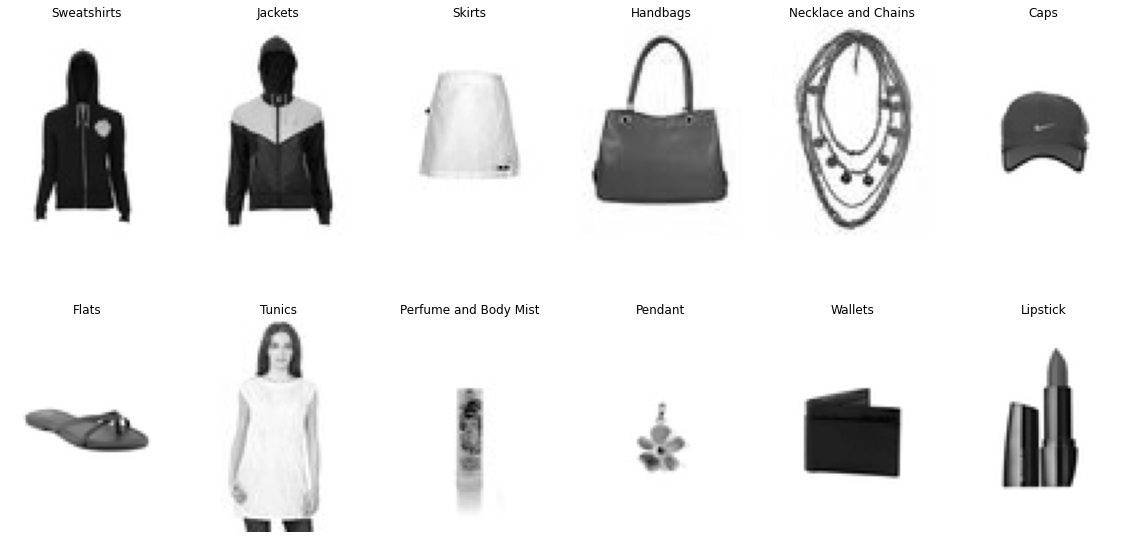

In [ ]:
categorizedProducts, categorizedProductsIndices = showExamples(classes, dataset)

نمایش توزیع داده در هر محصول:

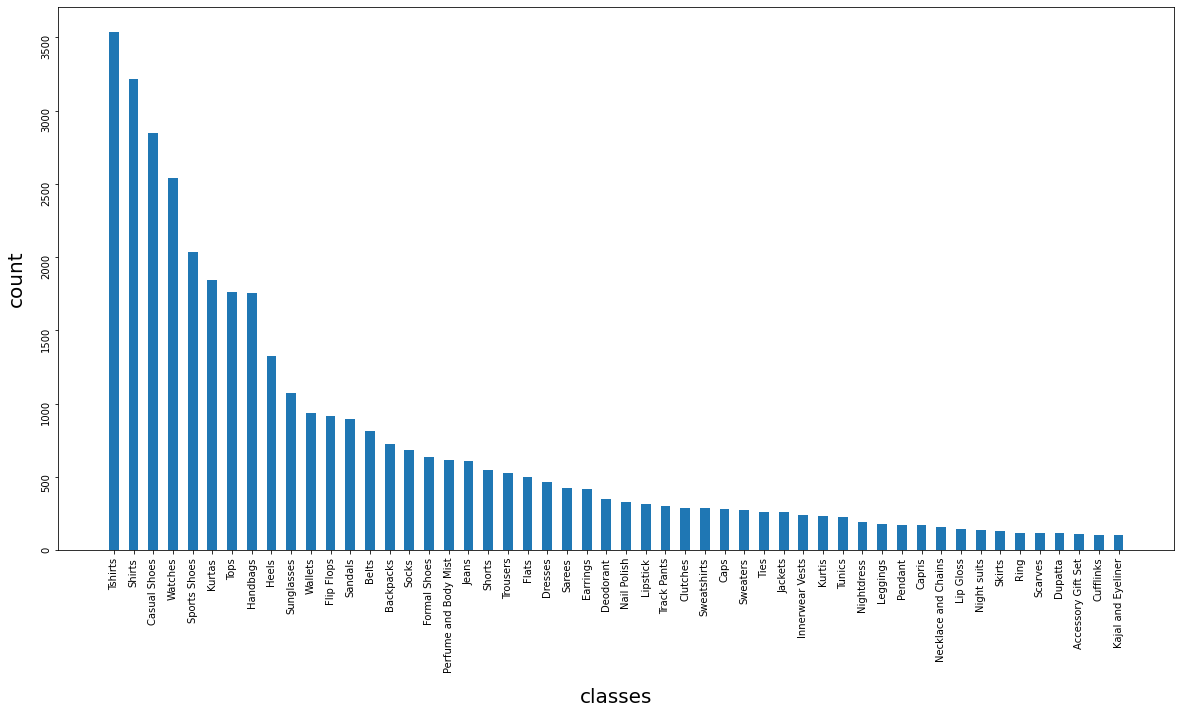

In [ ]:
drawPlot(categorizedProducts, classes)

Phase 3:

در کلاس model که از کلاس nn.module ارث بری میکند، یک شبکه عصبی با مجموع 4 لایه میسازیم

در لایه اول، ورودی به اندازه ابعاد هر عکس میباشد.
سپس ابعاد مربوط به خروجی لایه اول و ورودی و خروجی لایه های میانی را تعیین میکنیم.
تعداد خروجی های لایه آخر هم به اندازه تعداد دسته های محصولات است. 
بنابراین برای هر تصویر، در نهایت برداری با اندازه 52 که همان تعداد دسته ی محصولات است داریم. و پاسخ نهایی مدل همان کلاسی است که در این بردار بیشترین احتمال را دارد.

تابع سازنده این کلاس، تعداد دسته ها و تابع activation function را به عنوان ورودی میگیرد. تابع forward  را هم متناسب با این مدل بازنویسی میکنیم.

برای انتخاب این پارامتر ها، چندین بار با مقادیر مختلف برای تعداد لایه ها و ابعاد پارامتر های هر لایه، امتحان میکنیم و دقت و زمان را در نظر میگیریم.
تعداد لایه ها باید متناسب با پیچیدگی مدل باشند. اگر تعداد لایه ها خیلی کم باشد، مدل دچار underfitting میشود و خوب کرنمیکند.
همچنین اگر تعداد لایه ها از تعداد مافی برای این مدل بیشتر شود، باعث میشود که مدل دچار overfitting شود و روی داده آموزش خیلی دقیق شود اما در مواجهه با داده جدید که تا به حال ندیده، بسیار بد عمل کند. و هرچه تعداد لایه های میانی بیشتر باشد، مدل زودتر به نقطه اورفیت شدن نزدیک میشود.
در این پروژه چون تعداد دور های آموزش برابر با 10 میباشد، اگر تعداد لایه ها زیاد باشند و مدل عمیق تر شود، نیاز به تعداد بار های آموزش بیشتری است تا نتیجه بهتر و مطلوب حاصل شود. 
بنابراین در مجموع، افزایش بیش از حد و کاهش بیش از حد تعداد لایه ها نتیجه را بدتر مبکنند.
بنابراین پس از چندین بار امتحان کردن و مشاهده دقت و زمان اجرا، مقادیر زیر را انتخاب میکنیم.

برای انتخاب تعداد نورون های هر لایه نیز از همین روش آزمون و خطا جلو میرویم و نتایج آن مثل حالت قبل است.

In [ ]:
class Model(nn.Module):
    def __init__(self, class_num, act):
        super(Model, self).__init__()

        self.layer1 = nn.Linear(1 * 80 * 60, 2 * 40 * 30)
        self.act1 = act

        self.layer2 = nn.Linear(2 * 40 * 30, 4 * 20 * 15)
        self.act2 = act

        self.layer3 = nn.Linear(4 * 20 * 15, 8 * 10 * 10)
        self.act3 = act

        # self.layer4 = nn.Linear(8 * 10 * 10, 16 * 5 * 5)
        # self.act4 = act

        self.layer4 = nn.Linear(8 * 10 * 10, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        # x = self.layer4(x)
        # x = self.act4(x)

        x = self.layer4(x)
        return x

مقادیر learning rate و تابع محاسبه لاس را تعیین میکنیم

In [ ]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()

در اولین مرحله، بدون این که عکس ها را نرمال کنیم و پیش پردازش بیشتری از گری اسکیل روی آن ها انجام دهیم، شبکه عصبی را با نرخ آموزش و تابع محاسبه لاس گفته شده روی داده آموزش، آموزش میدهیم.

در خروجی این تابع، ابتدا برای اطمینان از این که داده های آموزش و تست به درستی تقسیم شده اند، نحوه تقسیم بندی در هر دسته را مشاهده میکنیم.

In [ ]:
model1, train_loader1, test_loader1, avgLossOfEpochs1 = createAndFitModel(dataset, classes, categorizedProducts, categorizedProductsIndices, criterion, learning_rate, 64, True, True)

Product Category Name:  Accessory Gift Set
Number of Samples:  111
Number of Samples In Train Set:  88
Number of Samples In Test Set:  23
-
Product Category Name:  Backpacks
Number of Samples:  722
Number of Samples In Train Set:  577
Number of Samples In Test Set:  145
-
Product Category Name:  Belts
Number of Samples:  813
Number of Samples In Train Set:  650
Number of Samples In Test Set:  163
-
Product Category Name:  Capris
Number of Samples:  175
Number of Samples In Train Set:  140
Number of Samples In Test Set:  35
-
Product Category Name:  Caps
Number of Samples:  283
Number of Samples In Train Set:  226
Number of Samples In Test Set:  57
-
Product Category Name:  Casual Shoes
Number of Samples:  2846
Number of Samples In Train Set:  2276
Number of Samples In Test Set:  570
-
Product Category Name:  Clutches
Number of Samples:  290
Number of Samples In Train Set:  232
Number of Samples In Test Set:  58
-
Product Category Name:  Cufflinks
Number of Samples:  106
Number of Sampl

همانطور که دیده میشود، مقادیر پارامتر ها (وزن و بایاس) برای این مدل را به ازای هر لایه نشان دادیم. که مطابق فرمولی که قبلا گفته شد محاسبه میشوند.
(بایاس به جلوگیری از اورفیت شدن کمک میکند.(
  

همان طور که دیده میشود مقدار لاس برای این مرحله nan میشود.
به این دلیل که عکس ها نرمال نشده اند و در بازه ی بزرگی قرار دارند و اعداد مربوط به خطا و لاس انقدر بزرگ میشوند که از اندازه float خارج شده و سرریز میکنند. بنابراین مقدار آن را nan میگیرد

برای از بین بردن این حالت میتوان تعداد لایه ها را زیاد کرد اما همانطور که گفته شد، این افزایش دادن معایب زیادی دارد و چون دیتا ی نرمال نشده معیار کار ما نیست، برای افزایش دقت آن، مدل را به هم نمیریزیم.
پس به دلایل گفته شده و لاس خیلی زیاد، همبنطور که انتظار میروز دقت بسیار پایین است و تمام داده ها را از یک نوع تشخیص میدهد(ممکن است در بعضی اجرا ها این اتفاق نیفتد اما خیلی اوقات همین طور میشود و یا 2 یا 3 دسته در جواب هایش دارد نهایتا)

سپس دقت به ازای هر کلاس و نمودار تغییرات میانگین لاس را نشان میدهیم

Test set accuracy:
Accuracy: 0.3078158458244111%
{'Accessory Gift Set': [23.0, 23.0], 'Backpacks': [0.0, 145.0], 'Belts': [0.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [0.0, 57.0], 'Casual Shoes': [0.0, 570.0], 'Clutches': [0.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [0.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [0.0, 84.0], 'Flats': [0.0, 100.0], 'Flip Flops': [0.0, 184.0], 'Formal Shoes': [0.0, 128.0], 'Handbags': [0.0, 352.0], 'Heels': [0.0, 265.0], 'Innerwear Vests': [0.0, 49.0], 'Jackets': [0.0, 52.0], 'Jeans': [0.0, 122.0], 'Kajal and Eyeliner': [0.0, 21.0], 'Kurtas': [0.0, 369.0], 'Kurtis': [0.0, 47.0], 'Leggings': [0.0, 36.0], 'Lip Gloss': [0.0, 29.0], 'Lipstick': [0.0, 63.0], 'Nail Polish': [0.0, 66.0], 'Necklace and Chains': [0.0, 32.0], 'Night suits': [0.0, 29.0], 'Nightdress': [0.0, 38.0], 'Pendant': [0.0, 35.0], 'Perfume and Body Mist': [0.0, 123.0], 'Ring': [0.0, 24.0], 'Sandals': [0.0, 180.0], 'Sarees': [0.0, 85.0], 'Scarves': [0.0, 24.0]

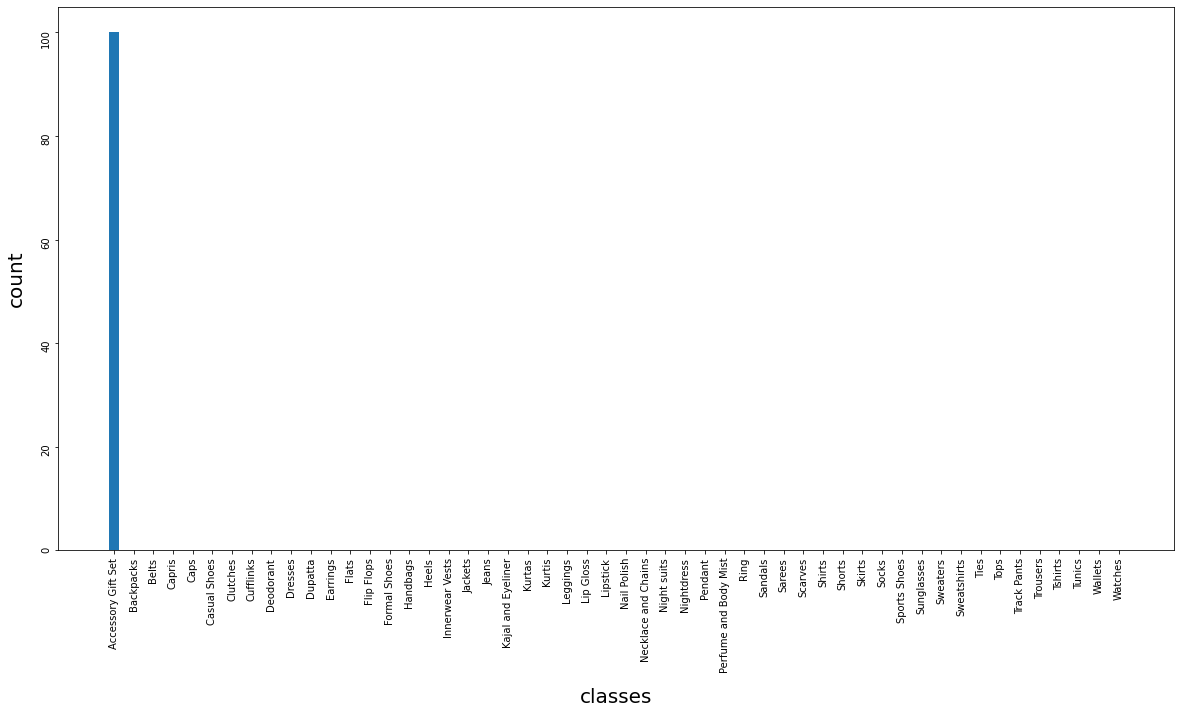

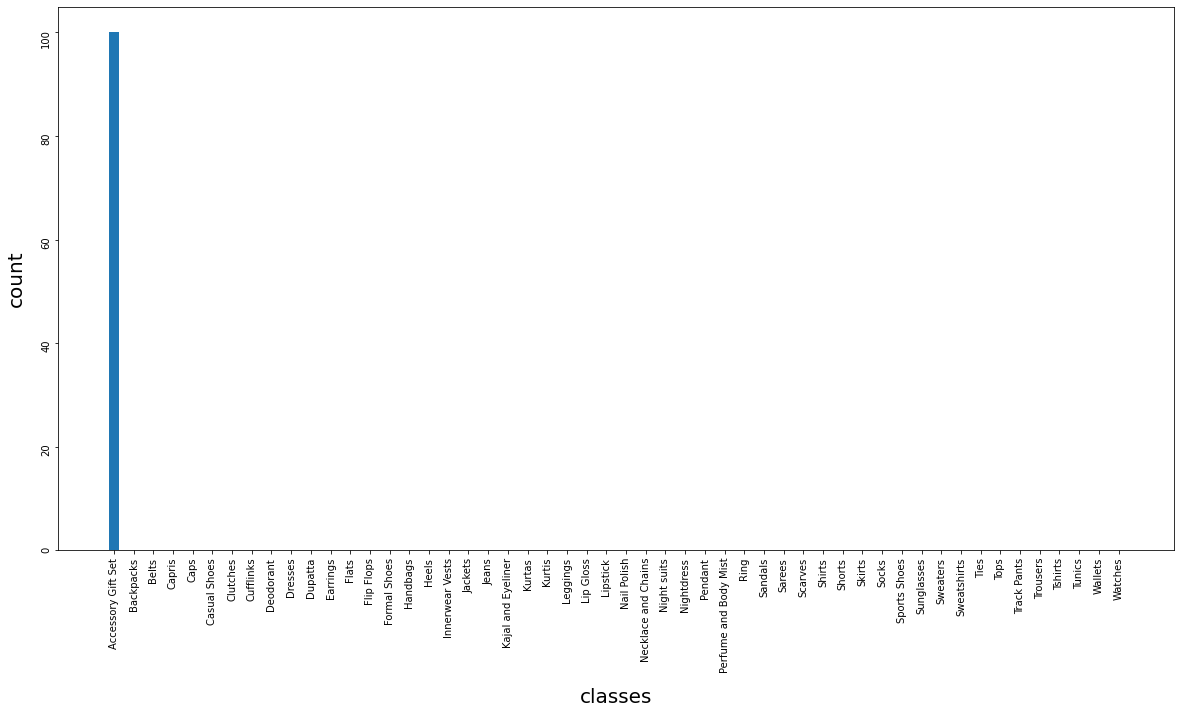

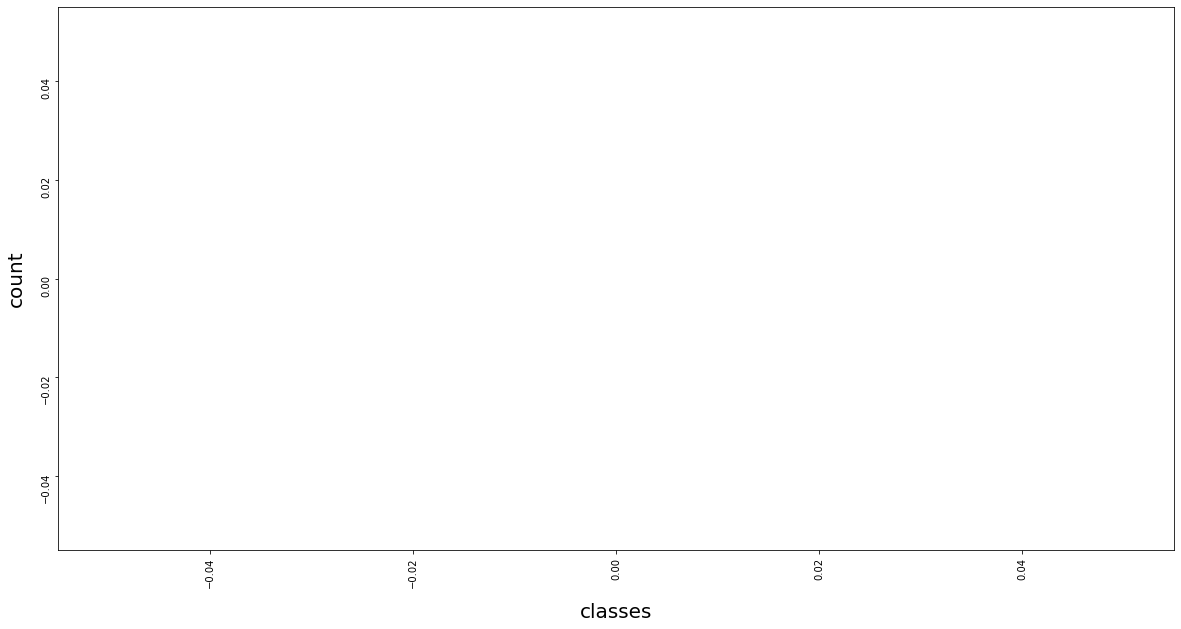

In [ ]:
printOutPuts(model1, train_loader1, test_loader1, classes, avgLossOfEpochs1)

Phase 4:

در این مرحله، در ابتدا داده ها را نرمال میکنیم که مشکلات گفته شده در قسمت قبل پیش نیایند.
همان طور که دیده میشود دقت بسیار افزایش میابد و بهتر میشود.

In [ ]:
class ToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""

    def __call__(self, image):
        image = np.array(image, dtype=np.float32) / 255
        # numpy image: H x W
        return torch.from_numpy(image)

In [ ]:
transform2 = transforms.Compose([transforms.Grayscale(), ToTensor()])

dataset2 = ImageFolder( "categorized_products", transform=transform2)
classes2 = dataset2.classes

dataset2[0]

(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]), 0)

In [ ]:
learning_rate2 = 0.01
criterion2 = nn.CrossEntropyLoss()

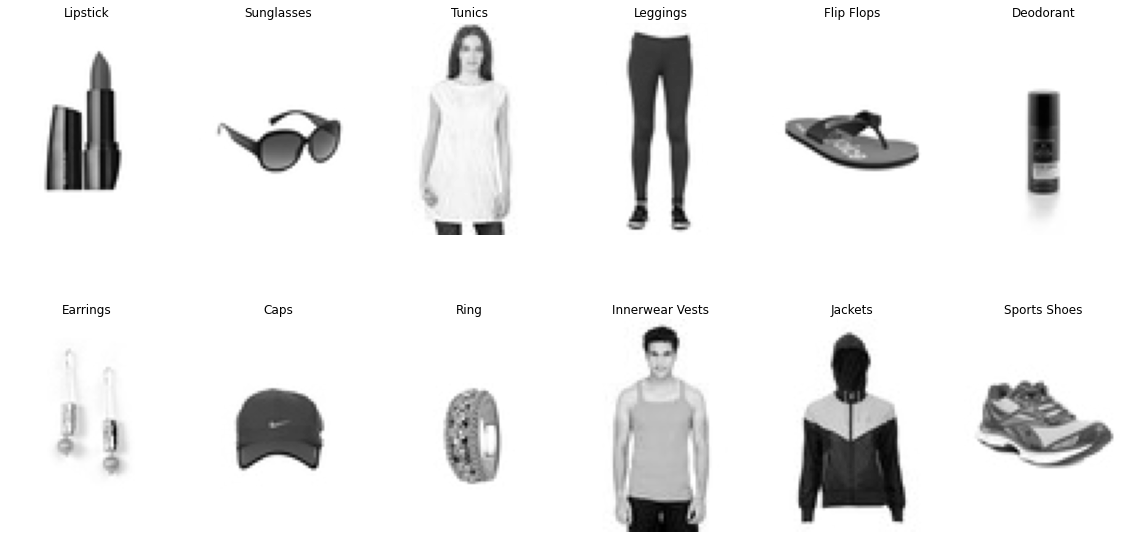

In [ ]:
categorizedProducts2, categorizedProductsIndices2 = showExamples(classes2, dataset2)

In [ ]:
model2, train_loader2, test_loader2, avgLossOfEpochs2 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, criterion2, learning_rate2)

epoch 1, train_loss: 3.207, time elapsed: 14.078342 seconds
epoch 2, train_loss: 2.422, time elapsed: 13.987066 seconds
epoch 3, train_loss: 1.989, time elapsed: 13.818045 seconds
epoch 4, train_loss: 1.744, time elapsed: 13.713075 seconds
epoch 5, train_loss: 1.599, time elapsed: 13.893713 seconds
epoch 6, train_loss: 1.497, time elapsed: 13.82166 seconds
epoch 7, train_loss: 1.417, time elapsed: 13.619235 seconds
epoch 8, train_loss: 1.344, time elapsed: 13.942471 seconds
epoch 9, train_loss: 1.297, time elapsed: 13.917257 seconds
epoch 10, train_loss: 1.245, time elapsed: 13.711312 seconds
total training time: 2.308 minutes


Test set accuracy:
Accuracy: 55.36670235546038%
{'Accessory Gift Set': [5.0, 23.0], 'Backpacks': [121.0, 145.0], 'Belts': [135.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [34.0, 57.0], 'Casual Shoes': [448.0, 570.0], 'Clutches': [29.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [28.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [70.0, 84.0], 'Flats': [0.0, 100.0], 'Flip Flops': [64.0, 184.0], 'Formal Shoes': [15.0, 128.0], 'Handbags': [313.0, 352.0], 'Heels': [255.0, 265.0], 'Innerwear Vests': [0.0, 49.0], 'Jackets': [8.0, 52.0], 'Jeans': [18.0, 122.0], 'Kajal and Eyeliner': [0.0, 21.0], 'Kurtas': [364.0, 369.0], 'Kurtis': [0.0, 47.0], 'Leggings': [1.0, 36.0], 'Lip Gloss': [10.0, 29.0], 'Lipstick': [46.0, 63.0], 'Nail Polish': [53.0, 66.0], 'Necklace and Chains': [2.0, 32.0], 'Night suits': [6.0, 29.0], 'Nightdress': [2.0, 38.0], 'Pendant': [12.0, 35.0], 'Perfume and Body Mist': [16.0, 123.0], 'Ring': [0.0, 24.0], 'Sandals': [18.0, 180.0], 'Sarees': [57.0, 85.0]

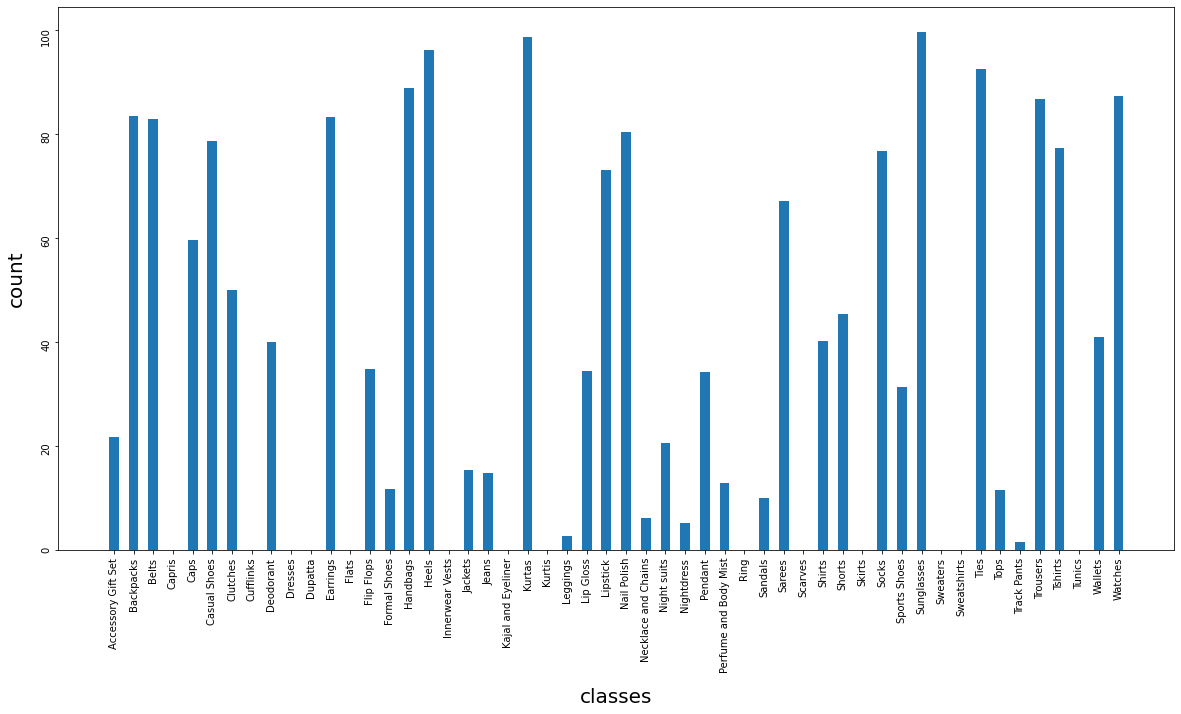

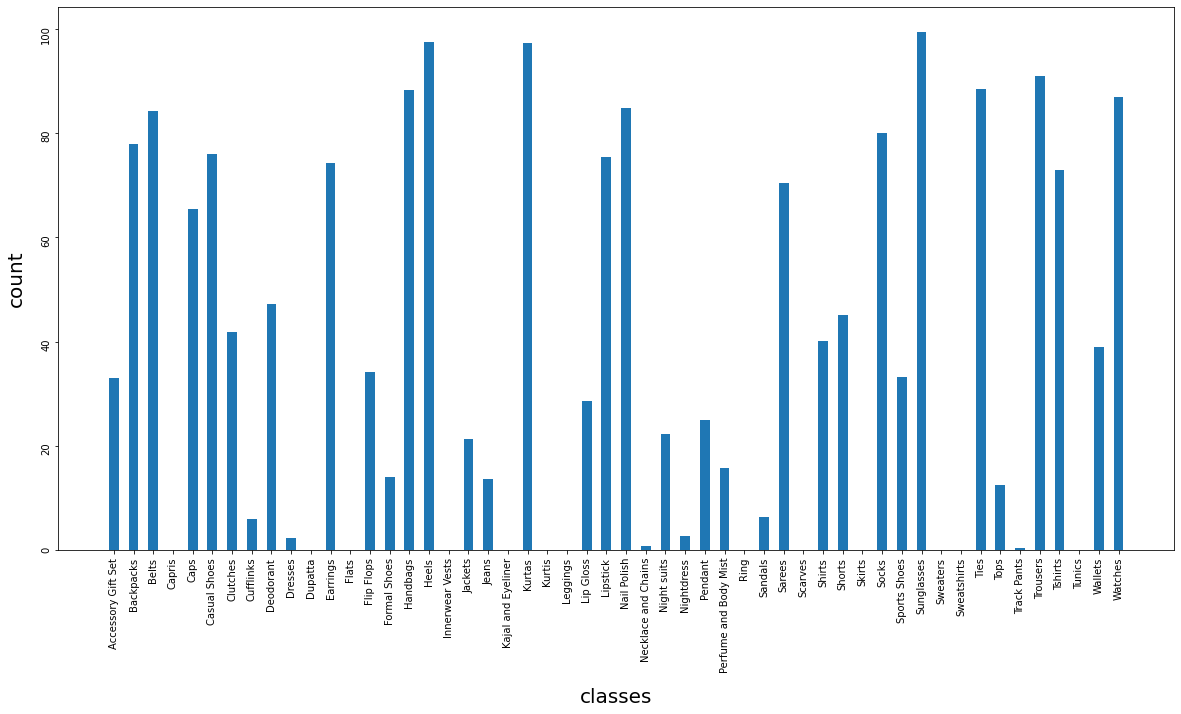

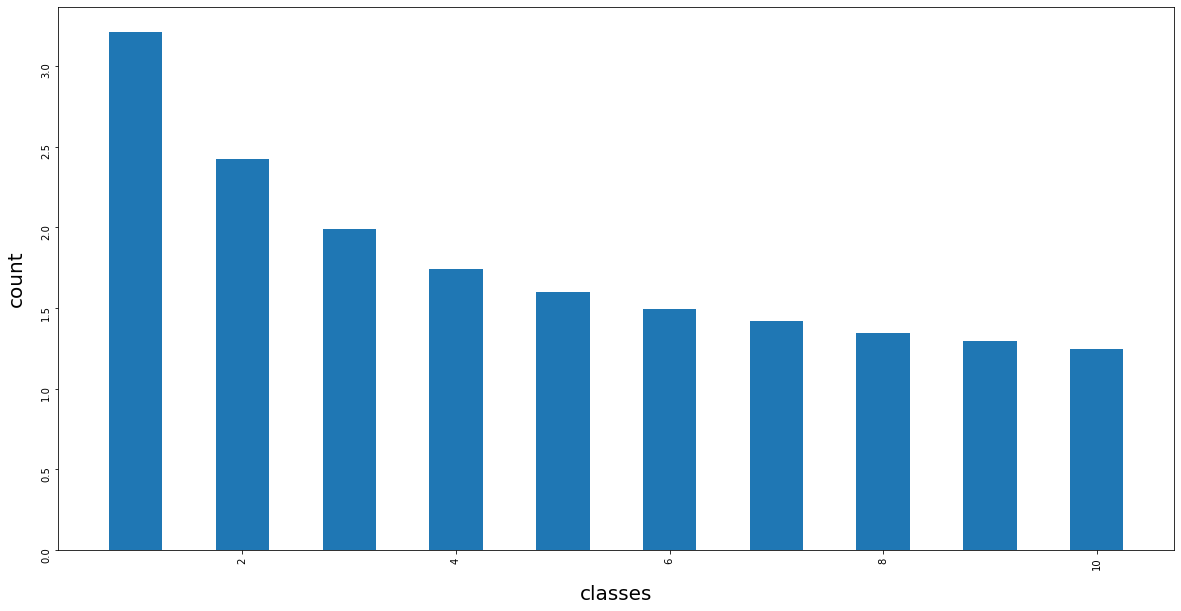

In [ ]:
printOutPuts(model2, train_loader2, test_loader2, classes2, avgLossOfEpochs2)

Phase 5:

در این بخش، به جای اینکه وزن ها را تصادفی انتخاب کنیم، تمام وزن ها را برای همه لایه ها صفر میکنیم.
اتفاقی که در این حالت میفتد این است که چون وزن ها صفر هستند، حاصل ضرب ویژگی ها در وزن ها هم صفر میشود و فقط بایاس با آن ها جمع میشود و وزن ها و ویژگی ها تاثیری نمیگذارند و وزن همه نورون ها یکسان است. در نتیجه وزن یال ها به روز رسانی نمیشود و تغییر نمیکند. بنابراین مدل عملا مانند یک کلسیفایر خطی عمل میکند و به آن تبدیل میشود.
دقت آن نیز به اندازه بیشترین زیرمجموعه داده ها است و بسیار پایین است.

بنابراین بهتر است که وزن ها تصادفی انتخاب شوند. زیرا در نتیجه ی این کار، از محل ها و نقاط متفاوتی شروع به حرکت میکنیم. بنابراین چون از نقاط مختلفی به سمت مینیمم میرویم، امکان این که در لوکال مینیمم گیر کنیم کمتر است و بهتر است.
اگر مثل حالت قبل همه وزن ها صفر باشند عملا هیچ آپدیت و آموزشی رخ نمیدهد و اگر همه وزن ها نشابه باشند نیز همه نورون ها شبیه به هم آپدیت میشوند. بنابراین بهتر است از همان روش انتخاب تصادفی استفاده کنیم

In [ ]:
learning_rate3 = 0.01
criterion3 = nn.CrossEntropyLoss()

In [ ]:
model3, train_loader3, test_loader3, avgLossOfEpochs3 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, criterion3, learning_rate3, 64, False, False, 0, True)

OrderedDict([('layer1.weight', tensor([[ 3.7363e-03, -1.3538e-02, -1.2550e-02,  ...,  1.1145e-02,
         -8.3519e-03,  1.4180e-02],
        [ 4.0043e-03,  6.0739e-04,  1.3344e-02,  ..., -9.7377e-03,
          4.6636e-03,  1.3032e-02],
        [-1.1311e-02,  9.7749e-03,  9.4728e-03,  ..., -2.7594e-04,
         -3.0772e-03, -8.4079e-03],
        ...,
        [ 3.6679e-03, -1.3576e-02,  3.5299e-03,  ...,  4.3777e-03,
         -8.7894e-03, -1.1189e-02],
        [-3.1593e-03,  3.7293e-03,  1.1061e-02,  ...,  5.1037e-03,
          6.7109e-03,  4.3277e-03],
        [ 1.4400e-05,  1.0833e-02, -4.9807e-03,  ..., -2.0026e-04,
         -3.9236e-03, -7.1372e-03]], device='cuda:0')), ('layer1.bias', tensor([-0.0010,  0.0049,  0.0132,  ...,  0.0060, -0.0128,  0.0071],
       device='cuda:0')), ('layer2.weight', tensor([[-0.0127, -0.0192,  0.0178,  ..., -0.0025,  0.0140,  0.0049],
        [-0.0121,  0.0023,  0.0100,  ...,  0.0187, -0.0059, -0.0189],
        [ 0.0138,  0.0168, -0.0201,  ..., -0.0150

Test set accuracy:
Accuracy: 15.65845824411135%
{'Accessory Gift Set': [0.0, 23.0], 'Backpacks': [0.0, 145.0], 'Belts': [0.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [0.0, 57.0], 'Casual Shoes': [274.0, 570.0], 'Clutches': [0.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [0.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [0.0, 84.0], 'Flats': [0.0, 100.0], 'Flip Flops': [0.0, 184.0], 'Formal Shoes': [0.0, 128.0], 'Handbags': [0.0, 352.0], 'Heels': [0.0, 265.0], 'Innerwear Vests': [0.0, 49.0], 'Jackets': [0.0, 52.0], 'Jeans': [0.0, 122.0], 'Kajal and Eyeliner': [0.0, 21.0], 'Kurtas': [0.0, 369.0], 'Kurtis': [0.0, 47.0], 'Leggings': [0.0, 36.0], 'Lip Gloss': [0.0, 29.0], 'Lipstick': [0.0, 63.0], 'Nail Polish': [0.0, 66.0], 'Necklace and Chains': [0.0, 32.0], 'Night suits': [0.0, 29.0], 'Nightdress': [0.0, 38.0], 'Pendant': [0.0, 35.0], 'Perfume and Body Mist': [0.0, 123.0], 'Ring': [0.0, 24.0], 'Sandals': [0.0, 180.0], 'Sarees': [0.0, 85.0], 'Scarves': [0.0, 24.0]

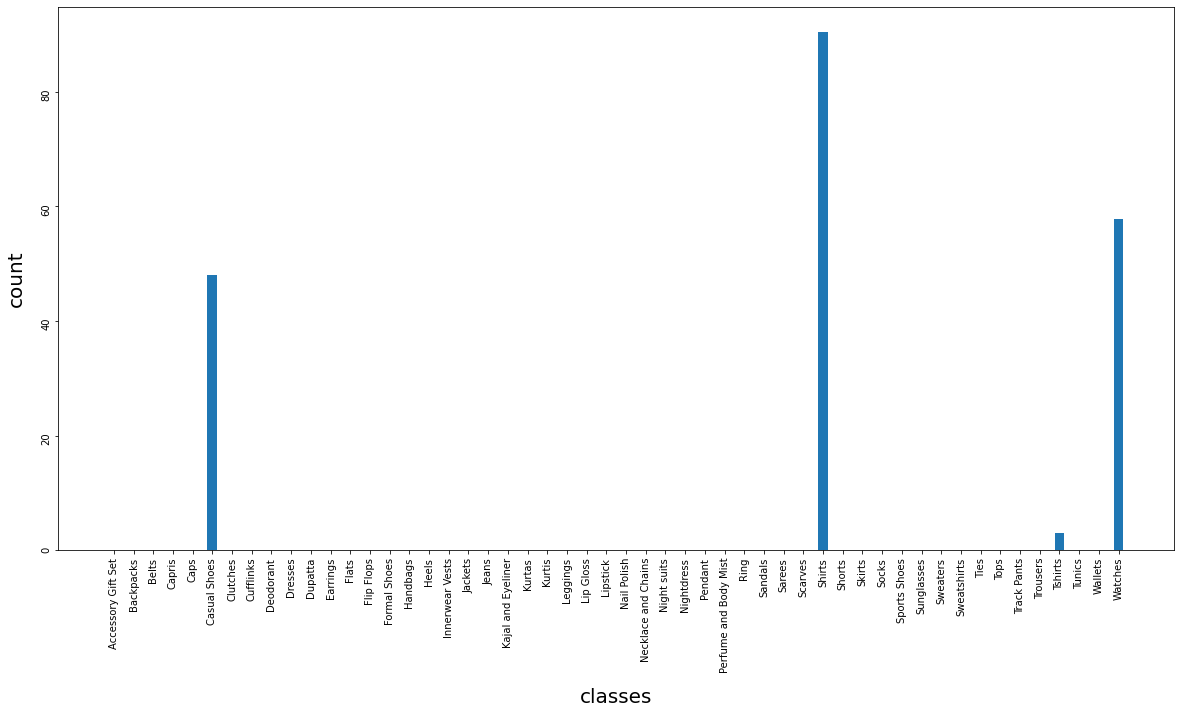

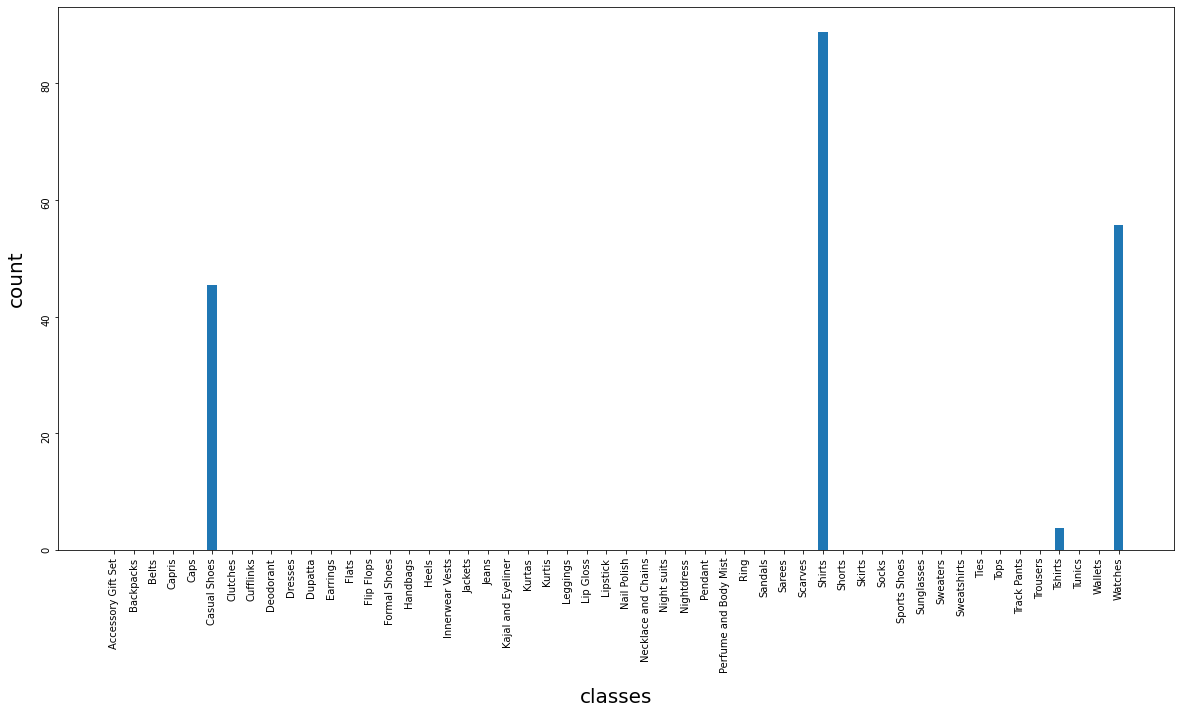

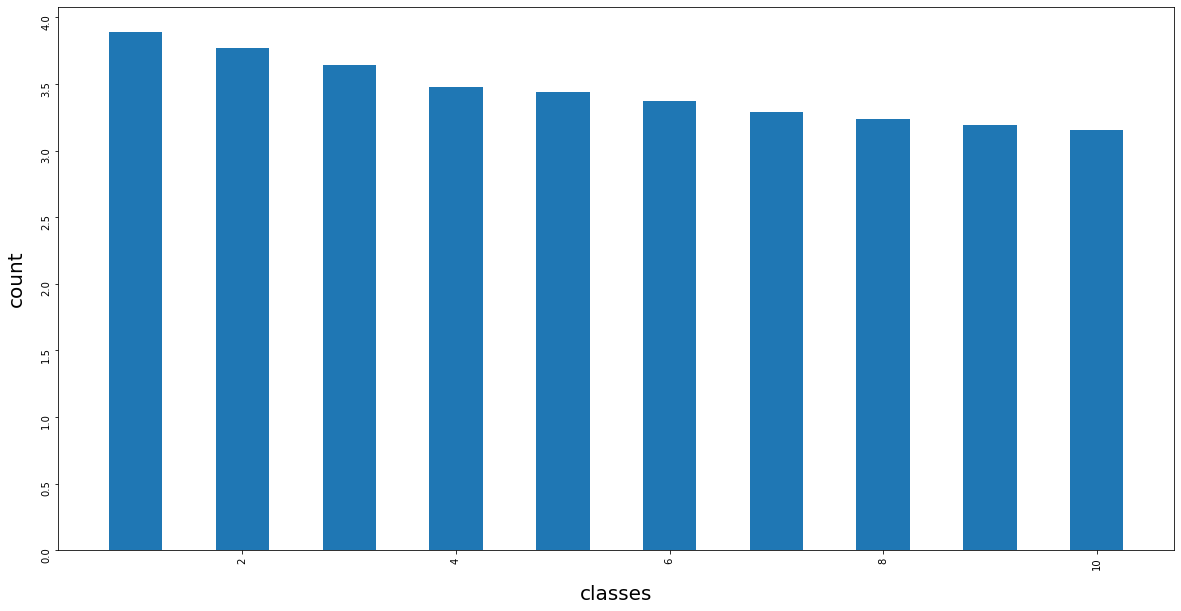

In [ ]:
printOutPuts(model3, train_loader3, test_loader3, classes2, avgLossOfEpochs3)

Phase 6:

نرخ یادگیری یکی از پارامتر های بسیار مهم در شبکه های عصبی است و بیان گر این است که برای تغییر دادن وزن ها، تا چه اندازه میتوانیم آن ها را تغییر وهیم و در چه محدوده ای میتوانیم این تغییر وزن ها را انجام دهیم.
بنابراین اگر این مقدار خیلی زیاد باشد، چون محدوده تغییر وزت ها زیاد میشود، ممکن است وزن ها را خیلی تغییر دهیم و overshoot کنیم.
همچنین اگر خیلی کم باشد نیز چون در هر بار آپدیت وزن ها، به مقدار کمی میتوانیم آپدیت کنیم(گام آپدیت کم است،) پس آموزش کند است و احتمال گیر کردن در جایی به جز بهترین جواب نیز وجود دارد.
در نتیجه اگر مقدار آن خیلی زیاد باشد، باعث میشود که مدل همگرا نشود و دایما نوسان کند.
اگر مقدار آن را خیلی کم کنیم، باعث میشود که آموزش مدل خیلی کند شود و همچنین در لوکال اوپتیمم گیر کند.

In [ ]:
def findBestLr(dataset, classes, categorizedProducts, categorizedProductsIndices, criterion, lrArray):
    result = {}
    for lr in lrArray:
        print("LR = ", lr)
        model, train_loader, test_loader, avgLossOfEpochs = createAndFitModel(dataset, classes, categorizedProducts, categorizedProductsIndices, criterion, lr)
        printAccs(model, train_loader, test_loader)
        result[lr] = test_model_accuracy(model, test_loader)
    return result


In [ ]:
lrArray = [0.0001, 0.001, 0.003, 0.005, 0.007, 0.009, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.8, 0.1, 0.4]

In [ ]:
res = findBestLr(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, criterion, lrArray)

LR =  0.0001
epoch 1, train_loss: 3.935, time elapsed: 14.869477 seconds
epoch 2, train_loss: 3.905, time elapsed: 13.622377 seconds
epoch 3, train_loss: 3.877, time elapsed: 13.68673 seconds
epoch 4, train_loss: 3.846, time elapsed: 13.871764 seconds
epoch 5, train_loss: 3.810, time elapsed: 13.735011 seconds
epoch 6, train_loss: 3.767, time elapsed: 13.736605 seconds
epoch 7, train_loss: 3.716, time elapsed: 13.999988 seconds
epoch 8, train_loss: 3.660, time elapsed: 13.760429 seconds
epoch 9, train_loss: 3.604, time elapsed: 13.623041 seconds
epoch 10, train_loss: 3.557, time elapsed: 13.664802 seconds
total training time: 2.310 minutes
Test set accuracy:
Accuracy: 9.461991434689507%
Train set accuracy:
Accuracy: 9.49390469154045%
Accuracy: 9.461991434689507%
LR =  0.001
epoch 1, train_loss: 3.767, time elapsed: 13.575038 seconds
epoch 2, train_loss: 3.454, time elapsed: 13.604075 seconds
epoch 3, train_loss: 3.399, time elapsed: 13.452337 seconds
epoch 4, train_loss: 3.344, time el

In [ ]:
for i in range(len(lrArray)):
    print("LR is:", lrArray[i], "Test Acc is:", res[lrArray[i]])

LR is: 0.0001 Test Acc is: 9.461991434689507
LR is: 0.001 Test Acc is: 25.7093147751606
LR is: 0.003 Test Acc is: 45.85117773019272
LR is: 0.005 Test Acc is: 46.94860813704497
LR is: 0.007 Test Acc is: 47.48394004282655
LR is: 0.009 Test Acc is: 54.014989293361886
LR is: 0.02 Test Acc is: 61.978051391862955
LR is: 0.03 Test Acc is: 60.184689507494646
LR is: 0.04 Test Acc is: 62.70074946466809
LR is: 0.05 Test Acc is: 58.99357601713062
LR is: 0.06 Test Acc is: 60.53265524625267
LR is: 0.07 Test Acc is: 60.438972162740896
LR is: 0.8 Test Acc is: 0.3078158458244111
LR is: 0.1 Test Acc is: 39.54764453961456
LR is: 0.4 Test Acc is: 9.461991434689507


Text(0, 0.5, 'Test Accuracy')

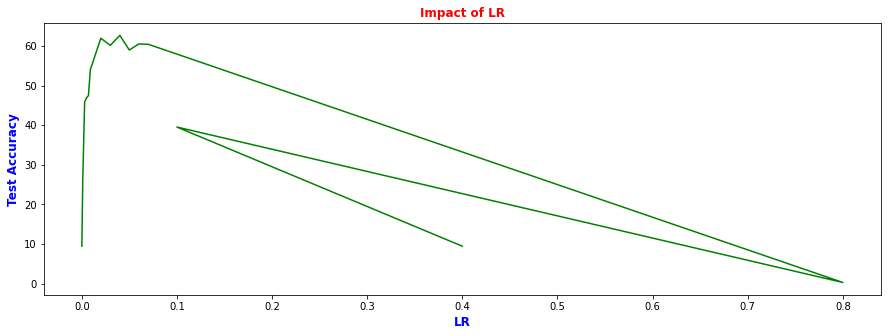

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(list(res.keys()), list(res.values()), color = 'g')
plt.title('Impact of LR', weight='bold', size='large', color = 'r')
plt.xlabel('LR', weight='bold', size='large', color = 'b')
plt.ylabel('Test Accuracy', weight='bold', size='large', color = 'b')

Text(0, 0.5, 'Test Accuracy')

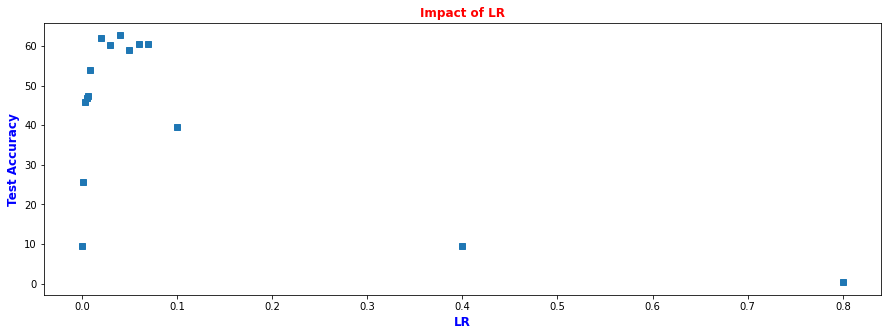

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(list(res.keys()), list(res.values()), 's')
plt.title('Impact of LR', weight='bold', size='large', color = 'r')
plt.xlabel('LR', weight='bold', size='large', color = 'b')
plt.ylabel('Test Accuracy', weight='bold', size='large', color = 'b')

In [ ]:
res2 = findBestLr(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, criterion, [0.05, 0.055, 0.06, 0.065])

LR =  0.05
epoch 1, train_loss: 2.721, time elapsed: 13.378857 seconds
epoch 2, train_loss: 1.912, time elapsed: 13.59352 seconds
epoch 3, train_loss: 1.590, time elapsed: 13.246573 seconds
epoch 4, train_loss: 1.404, time elapsed: 13.285923 seconds
epoch 5, train_loss: 1.293, time elapsed: 13.37888 seconds
epoch 6, train_loss: 1.208, time elapsed: 13.315334 seconds
epoch 7, train_loss: 1.134, time elapsed: 13.232963 seconds
epoch 8, train_loss: 1.079, time elapsed: 13.236195 seconds
epoch 9, train_loss: 1.031, time elapsed: 13.423872 seconds
epoch 10, train_loss: 0.985, time elapsed: 13.376069 seconds
total training time: 2.224 minutes
Test set accuracy:
Accuracy: 57.601713062098504%
Train set accuracy:
Accuracy: 58.54518588172079%
Accuracy: 57.601713062098504%
LR =  0.055
epoch 1, train_loss: 2.661, time elapsed: 13.401701 seconds
epoch 2, train_loss: 1.849, time elapsed: 13.434022 seconds
epoch 3, train_loss: 1.540, time elapsed: 13.310836 seconds
epoch 4, train_loss: 1.367, time el

In [ ]:
bestLr = 0.06

 همانطور که دیده میشود، برای نرخ های خیلی زیاد مثل 0.4، مقدار لاس نزولی نبود و تغییرات آن نیز بسیار اندک بود و به جواب بهتر نزدیک نمیشدیم.
 در حالتی که خیلی کم بود نیز فرایند آموزش بسیار آهسته بود.
 در هر دو حالت نیز دقت خیلی کمی داشتیم.

Phase 7:

batch size نیز از پارامتر های خیلی مهم در شبکه های عصبی است و در رسیدن به بهترین جواب و سرعت همگرا شدن مدل تاثیر میگذارد.
اگر اندازه آن را خیلی بزرگ انتخاب کنیم، generalization را از دست میدهیم .
به طور مثال اگر اندازه آن را برابر با بیشترین مقدار، یعنی اندازه کل دیتا، قرار دهیم، تضمین میشود که حتما به گلوبال اوپتیمم میرسیم اما سرعت کمتر میشود و با سرعت کمی به این اوپتیمم میرسیم.
همچنین اگر اندازه آن را کوچک انتخاب کنیم، با سرعت بیشنری به یک جواب خوب همگرا میشویم(که لزوما گلوبال اوپتیمم نیست و لوکال است) در این حالت در واقع مدل قبل از اینکه تمام دیتا را دیده باشد، آموزش را آغاز میکند.اما در این حالت تضمینی برای رسیدن به گلوبال اوپتیمم وجود ندارد. و اطراف آن جهش میکند که فاصله از گلوبال اوپتیمم نیز به اندازه آن نسبت به اندازه کل دیتا بستگی دارد. در این حالت همچنین نویز بیشتری داریم (عدم تضمین)


epoch 1, train_loss: 2.417, time elapsed: 16.77646 seconds
epoch 2, train_loss: 1.649, time elapsed: 16.821217 seconds
epoch 3, train_loss: 1.390, time elapsed: 16.018151 seconds
epoch 4, train_loss: 1.253, time elapsed: 16.325138 seconds
epoch 5, train_loss: 1.150, time elapsed: 15.919966 seconds
epoch 6, train_loss: 1.079, time elapsed: 16.009264 seconds
epoch 7, train_loss: 1.020, time elapsed: 15.983937 seconds
epoch 8, train_loss: 0.968, time elapsed: 15.877537 seconds
epoch 9, train_loss: 0.927, time elapsed: 15.932207 seconds
epoch 10, train_loss: 0.887, time elapsed: 15.895638 seconds
total training time: 2.693 minutes
Test set accuracy:
Accuracy: 67.49197002141328%
{'Accessory Gift Set': [22.0, 23.0], 'Backpacks': [130.0, 145.0], 'Belts': [163.0, 163.0], 'Capris': [10.0, 35.0], 'Caps': [40.0, 57.0], 'Casual Shoes': [413.0, 570.0], 'Clutches': [42.0, 58.0], 'Cufflinks': [8.0, 22.0], 'Deodorant': [45.0, 70.0], 'Dresses': [25.0, 93.0], 'Dupatta': [12.0, 24.0], 'Earrings': [44.0, 

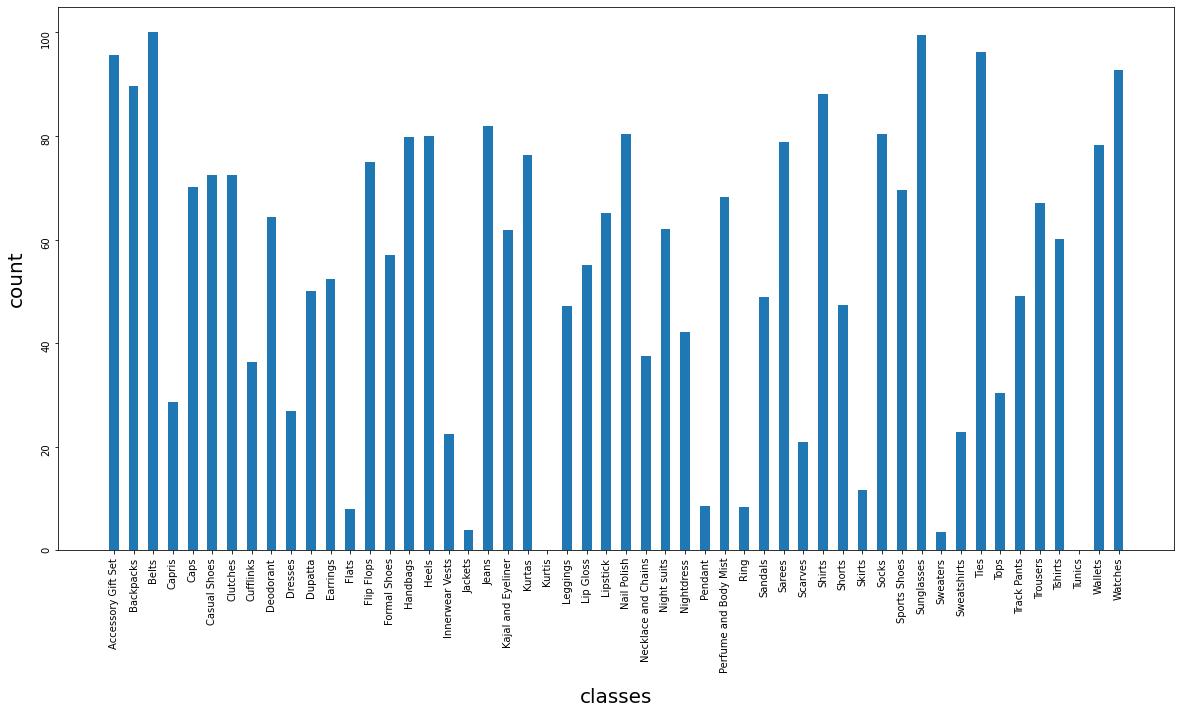

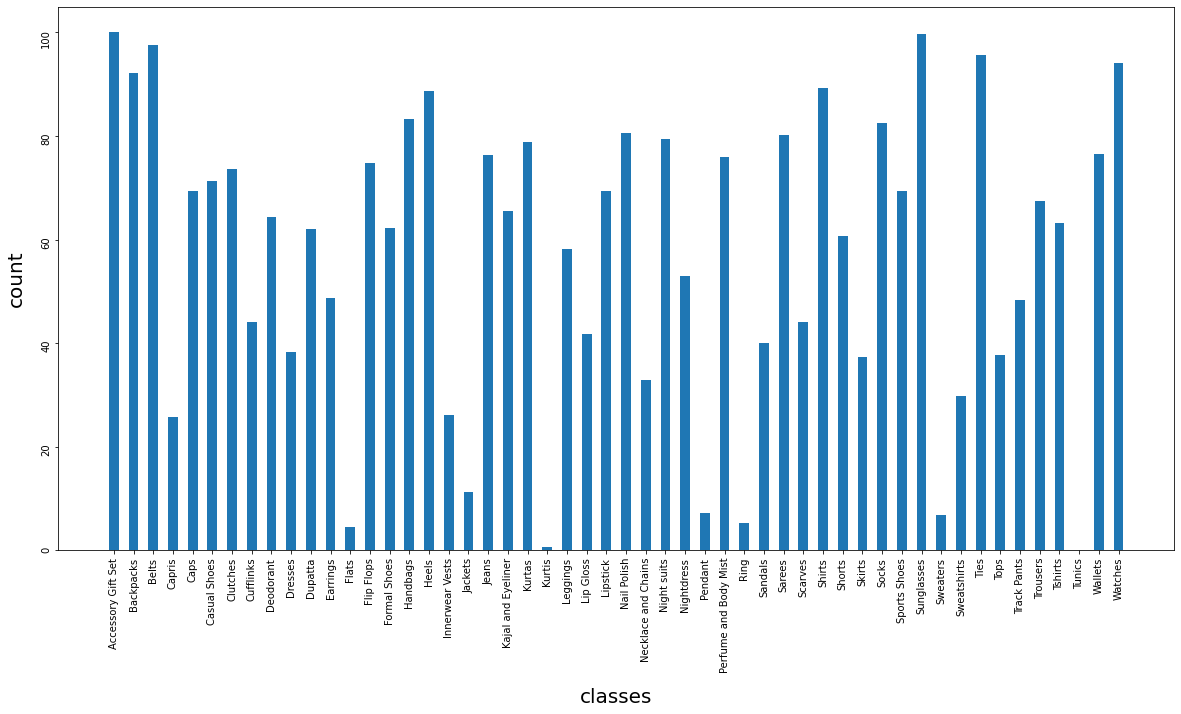

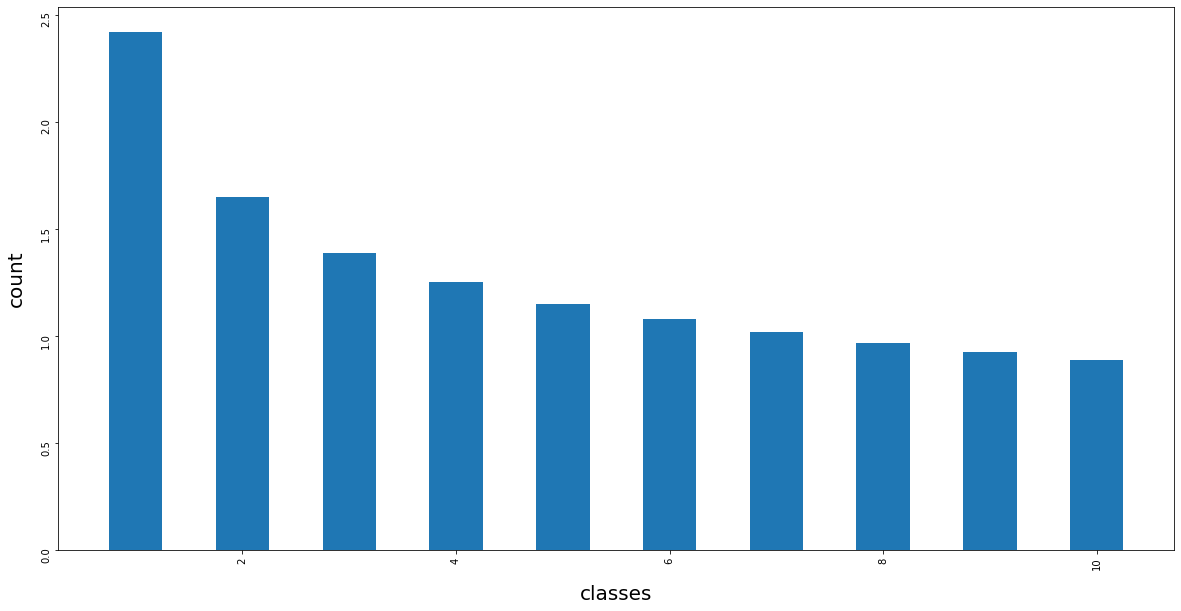

In [ ]:
commonCriterion = nn.CrossEntropyLoss()
model12, train_loader12, test_loader12, avgLossOfEpochs12 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 32)
printOutPuts(model12, train_loader12, test_loader12, classes2, avgLossOfEpochs12)

epoch 1, train_loss: 2.946, time elapsed: 14.478988 seconds
epoch 2, train_loss: 2.209, time elapsed: 13.042569 seconds
epoch 3, train_loss: 1.849, time elapsed: 12.841283 seconds
epoch 4, train_loss: 1.610, time elapsed: 12.68335 seconds
epoch 5, train_loss: 1.471, time elapsed: 12.565926 seconds
epoch 6, train_loss: 1.372, time elapsed: 12.570945 seconds
epoch 7, train_loss: 1.285, time elapsed: 12.767439 seconds
epoch 8, train_loss: 1.220, time elapsed: 12.871028 seconds
epoch 9, train_loss: 1.179, time elapsed: 12.738711 seconds
epoch 10, train_loss: 1.127, time elapsed: 13.056612 seconds
total training time: 2.160 minutes
Test set accuracy:
Accuracy: 65.01605995717345%
{'Accessory Gift Set': [23.0, 23.0], 'Backpacks': [132.0, 145.0], 'Belts': [153.0, 163.0], 'Capris': [2.0, 35.0], 'Caps': [45.0, 57.0], 'Casual Shoes': [432.0, 570.0], 'Clutches': [27.0, 58.0], 'Cufflinks': [12.0, 22.0], 'Deodorant': [36.0, 70.0], 'Dresses': [36.0, 93.0], 'Dupatta': [8.0, 24.0], 'Earrings': [70.0, 8

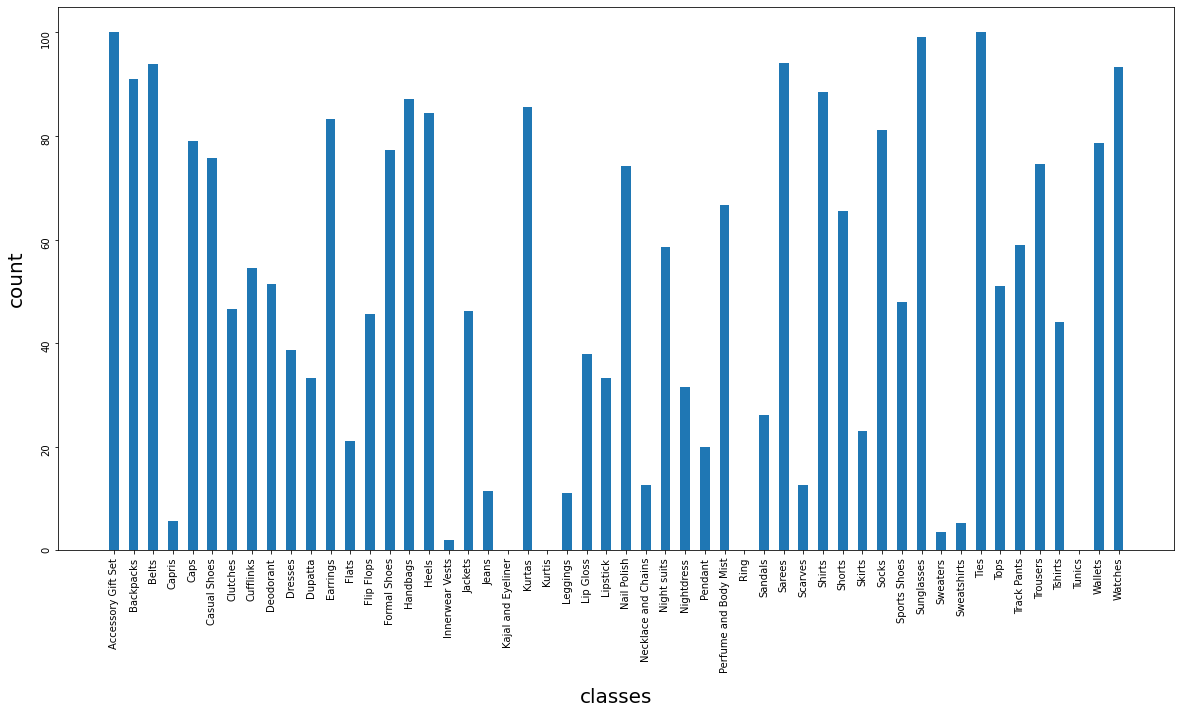

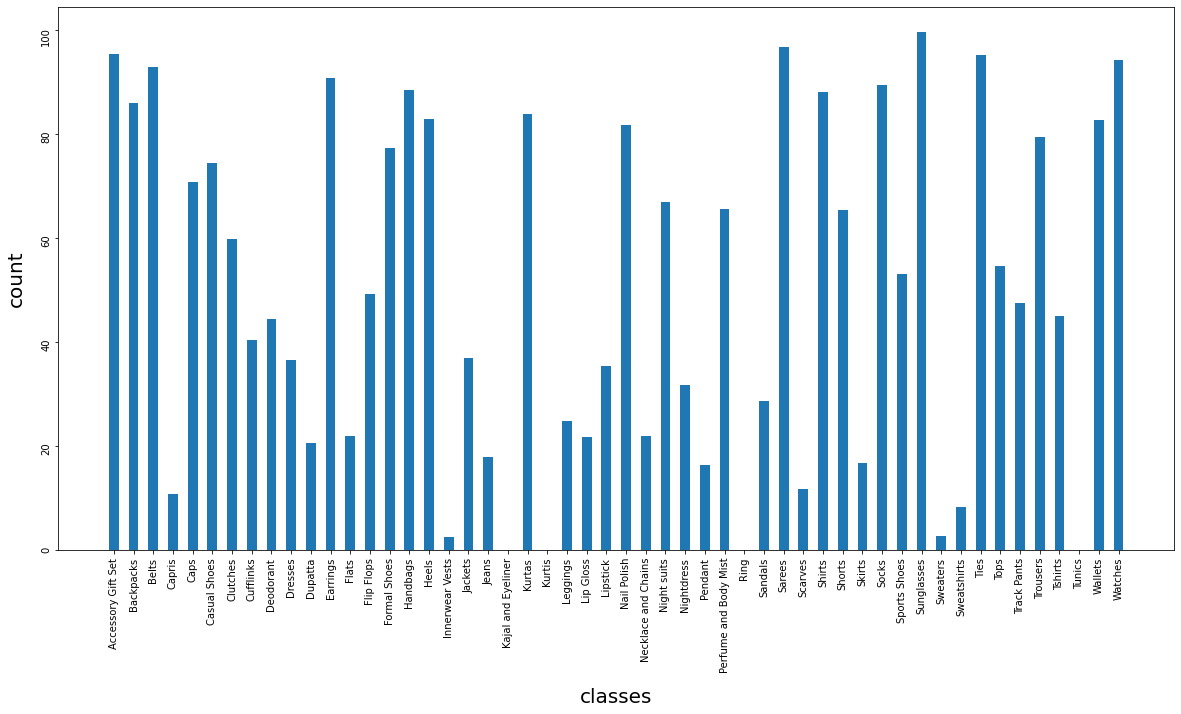

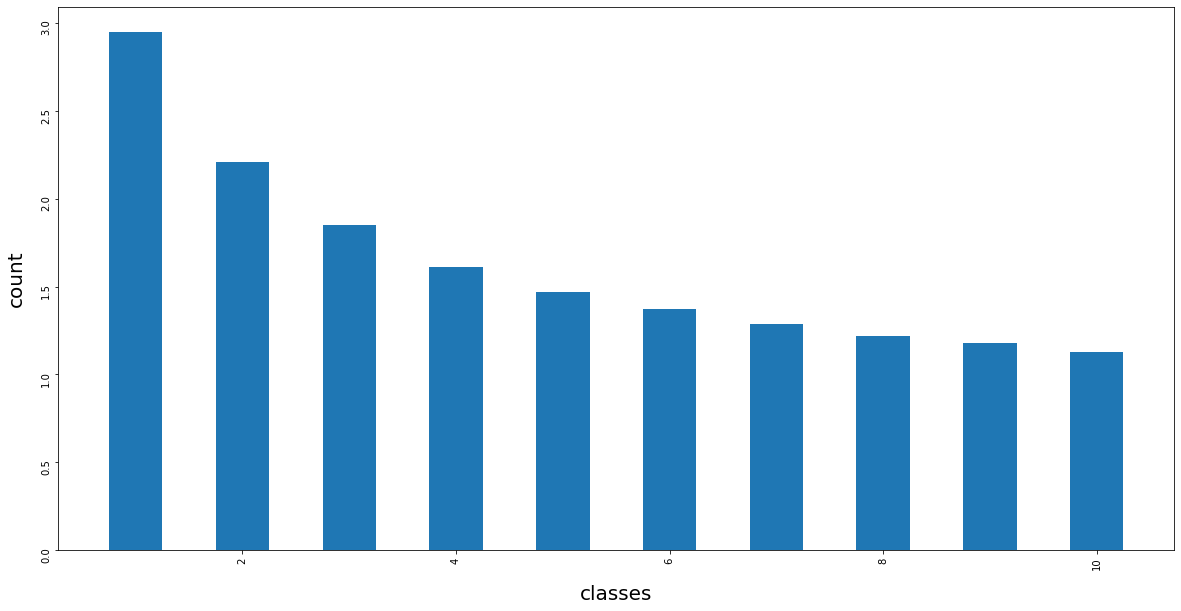

In [ ]:
model13, train_loader13, test_loader13, avgLossOfEpochs13 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 128)
printOutPuts(model13, train_loader13, test_loader13, classes2, avgLossOfEpochs13)

epoch 1, train_loss: 3.236, time elapsed: 13.168124 seconds
epoch 2, train_loss: 2.490, time elapsed: 12.868528 seconds
epoch 3, train_loss: 2.088, time elapsed: 12.858864 seconds
epoch 4, train_loss: 1.856, time elapsed: 12.891212 seconds
epoch 5, train_loss: 1.696, time elapsed: 12.899004 seconds
epoch 6, train_loss: 1.597, time elapsed: 13.039166 seconds
epoch 7, train_loss: 1.489, time elapsed: 12.955026 seconds
epoch 8, train_loss: 1.416, time elapsed: 12.870648 seconds
epoch 9, train_loss: 1.353, time elapsed: 13.058142 seconds
epoch 10, train_loss: 1.298, time elapsed: 13.112149 seconds
total training time: 2.162 minutes
Test set accuracy:
Accuracy: 57.521413276231264%
{'Accessory Gift Set': [13.0, 23.0], 'Backpacks': [112.0, 145.0], 'Belts': [140.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [24.0, 57.0], 'Casual Shoes': [246.0, 570.0], 'Clutches': [44.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [29.0, 70.0], 'Dresses': [8.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [70.0, 8

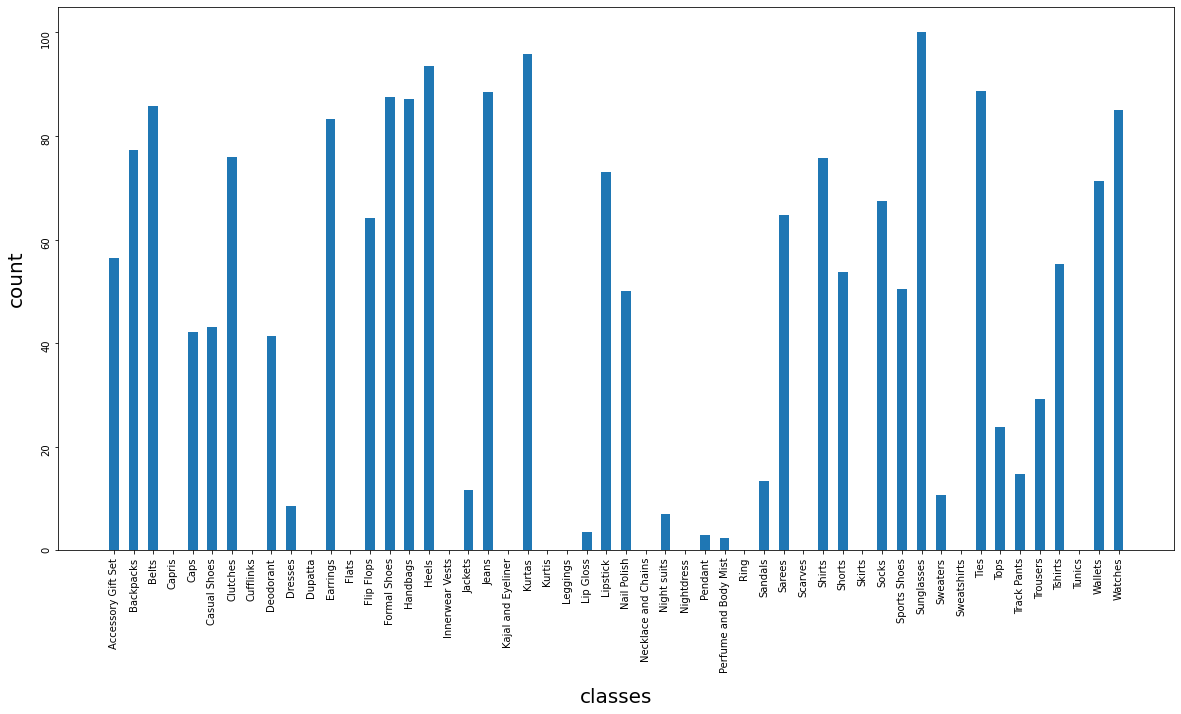

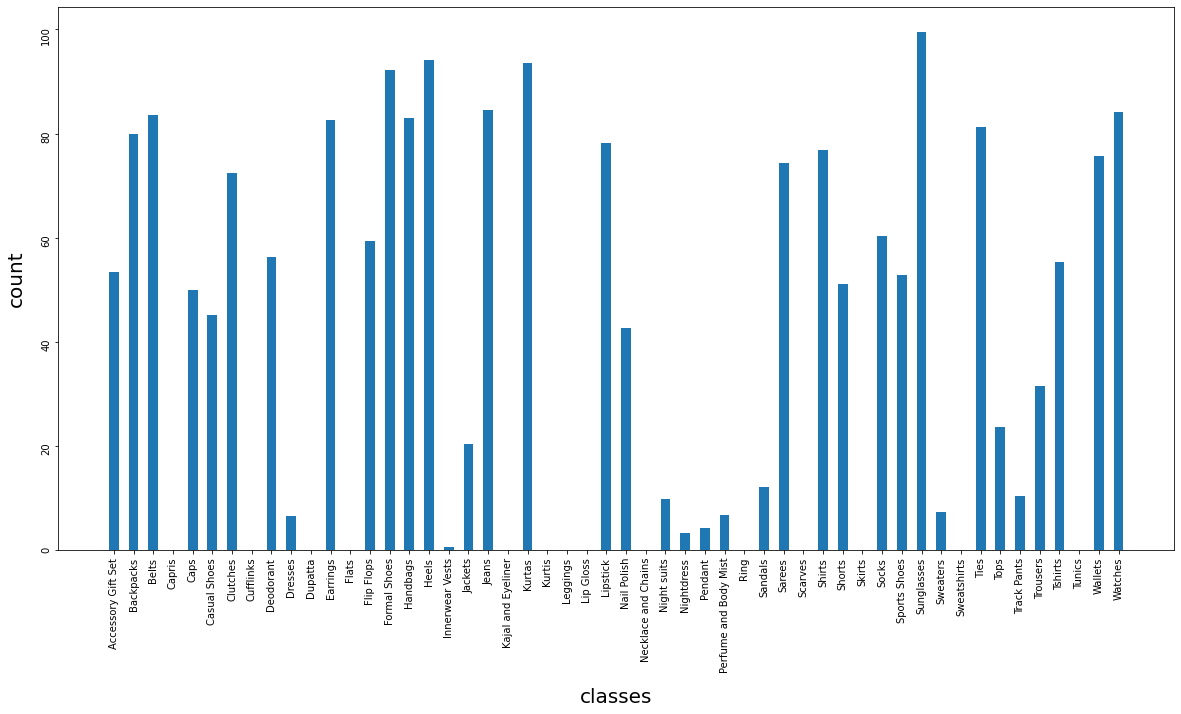

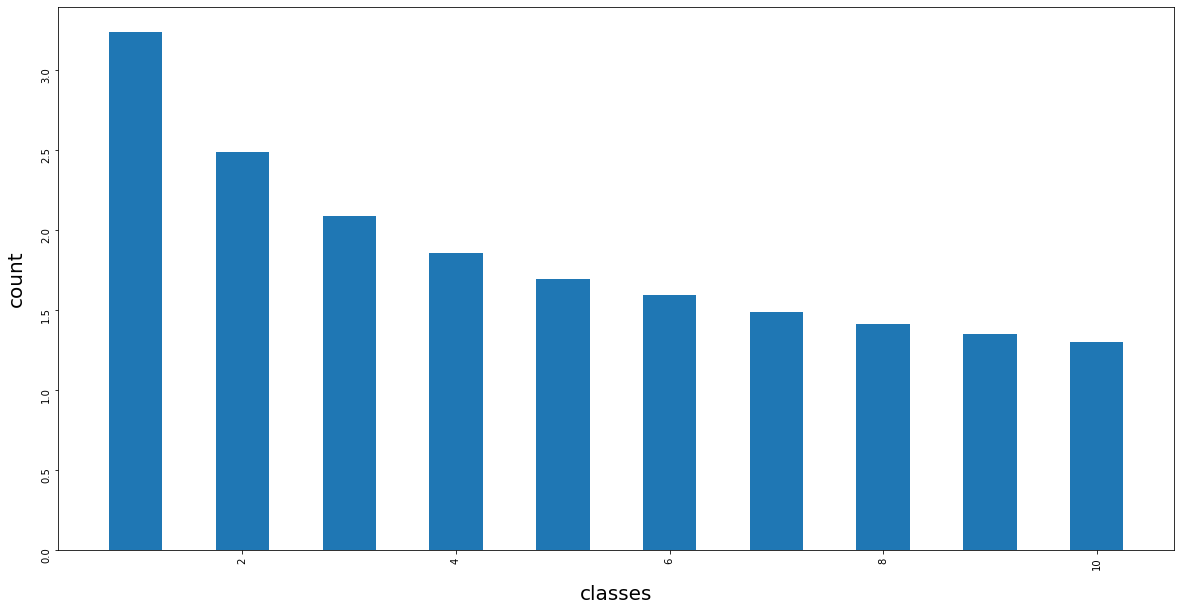

In [ ]:
model17, train_loader17, test_loader17, avgLossOfEpochs17 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, 0.02, 128)
printOutPuts(model17, train_loader17, test_loader17, classes2, avgLossOfEpochs17)

epoch 1, train_loss: 3.140, time elapsed: 13.266527 seconds
epoch 2, train_loss: 2.398, time elapsed: 13.055388 seconds
epoch 3, train_loss: 2.074, time elapsed: 12.97693 seconds
epoch 4, train_loss: 1.778, time elapsed: 12.988709 seconds
epoch 5, train_loss: 1.611, time elapsed: 12.88507 seconds
epoch 6, train_loss: 1.477, time elapsed: 13.118155 seconds
epoch 7, train_loss: 1.362, time elapsed: 13.012508 seconds
epoch 8, train_loss: 1.306, time elapsed: 12.943725 seconds
epoch 9, train_loss: 1.226, time elapsed: 13.131523 seconds
epoch 10, train_loss: 1.183, time elapsed: 13.303836 seconds
total training time: 2.178 minutes
Test set accuracy:
Accuracy: 61.48286937901499%
{'Accessory Gift Set': [21.0, 23.0], 'Backpacks': [96.0, 145.0], 'Belts': [147.0, 163.0], 'Capris': [4.0, 35.0], 'Caps': [38.0, 57.0], 'Casual Shoes': [427.0, 570.0], 'Clutches': [26.0, 58.0], 'Cufflinks': [7.0, 22.0], 'Deodorant': [31.0, 70.0], 'Dresses': [23.0, 93.0], 'Dupatta': [4.0, 24.0], 'Earrings': [16.0, 84.0

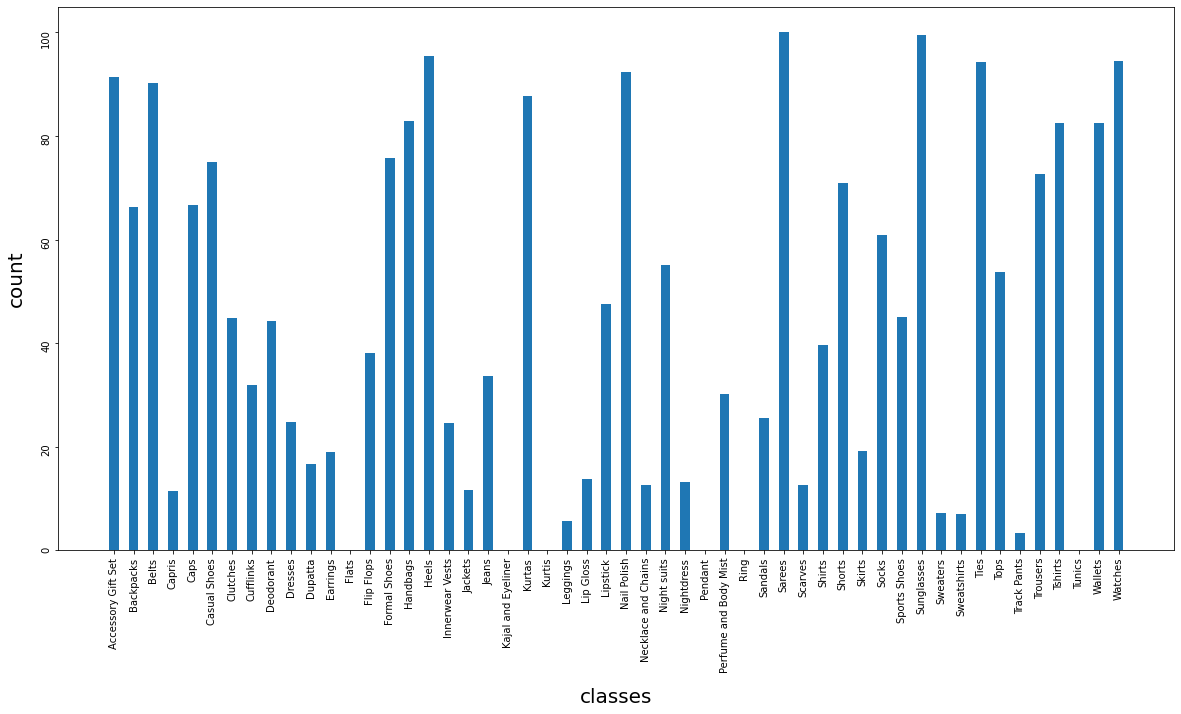

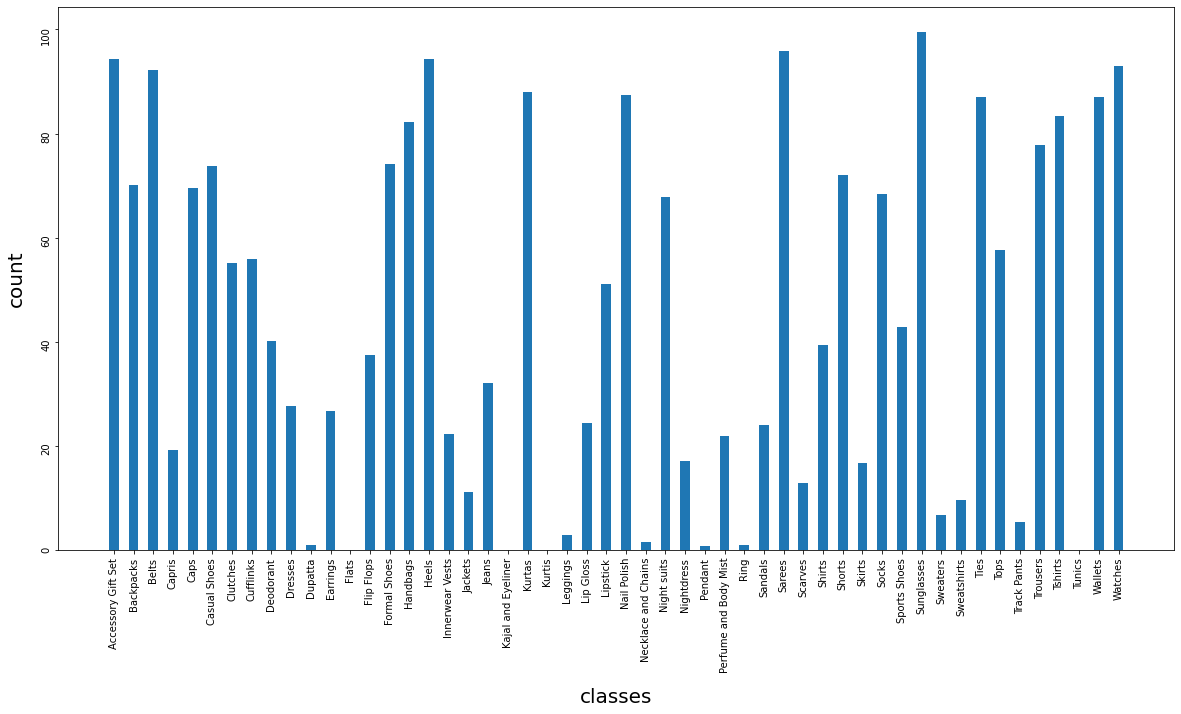

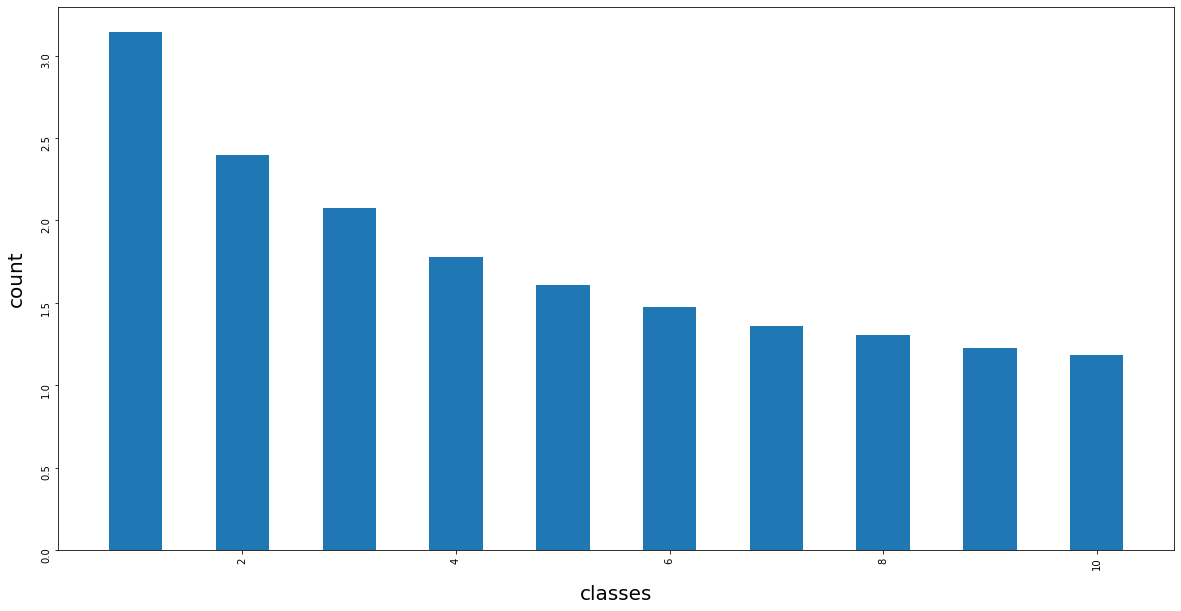

In [ ]:
model18, train_loader18, test_loader18, avgLossOfEpochs18 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, 0.1, 128)
printOutPuts(model18, train_loader18, test_loader18, classes2, avgLossOfEpochs18)

همانطور که دیده میشود، در batch size بزرگ تر، بهتر است از نرخ یادگیری بالاتر استفاده کنیم و دقت در این حالت بهتر از حالتی است که نرخ یادگیری کم میباشد.
زیرا اگر batch size بزرگتر باشد، اندازه داده بزرگتر است و با اطمینان بیشتر و گام های بزگتری در تغییر وزن میتوانیم پیش برویم تا خطا را مینیمم کنیم.

Phase 8:

از مومنتوم برای این که در یافتن خطای کمینه در مینیمم محلی گیر نیفتیم استفاده میکنیم. به این صورت با ما کمک میکند که گام ها را افزایش میدهد تا بتوانیم در صورت گیر افتادن در مینیمم محلی، از آن پرش کنیم و خارج شویم و گلوبال مینیمم را بیابیم. وقتی مقدار مومنتوم را زیاد میکنیم، باید مقدار نرخ یادگیری را کاهش دهیم زیرا زیاد بودن مومنتوم به این معنی است که گام ها بزرگتر هستند و زود تر همگرا میشویم اما اگر هر دوی ابن مقادیر زیاد باشند، باعث میشود که با یک گام بزرگ، از مینیمم رد شویم! اگر مقدار آن را کم انتخاب کنیم نیز تضمینی به ما نمیدهد که در مینیمم محلی گیر نیفتیم. مومنتوم همچنین باعث میشود که مدل smooth تری داشته باشیم. (که در حلتی که نوسان زیادی داریم خوب است)

همانطور که در مدل ما دیده میشود، چون از نرخ یاد گیری بهینه استفاده میکنیم و مقدار نرخ یادگیری زیاد است، بنابراین مقادیر بالای مومنتوم در مدل ما باعث میشوند که نتیجه بد تر شود. در این حالت مومنتوم با مقدار 0.5 برای ما نتیجه بهتری نسبت به بقیه مقادیر دارد.

In [ ]:
model19, train_loader19, test_loader19, avgLossOfEpochs19 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, 0.5)

epoch 1, train_loss: 2.602, time elapsed: 14.560205 seconds
epoch 2, train_loss: 1.791, time elapsed: 14.593575 seconds
epoch 3, train_loss: 1.483, time elapsed: 14.145513 seconds
epoch 4, train_loss: 1.365, time elapsed: 14.248562 seconds
epoch 5, train_loss: 1.236, time elapsed: 14.320541 seconds
epoch 6, train_loss: 1.133, time elapsed: 14.125003 seconds
epoch 7, train_loss: 1.048, time elapsed: 14.029819 seconds
epoch 8, train_loss: 1.021, time elapsed: 14.279899 seconds
epoch 9, train_loss: 0.957, time elapsed: 14.078662 seconds
epoch 10, train_loss: 0.921, time elapsed: 14.238891 seconds
total training time: 2.377 minutes


Test set accuracy:
Accuracy: 54.73768736616702%
{'Accessory Gift Set': [21.0, 23.0], 'Backpacks': [90.0, 145.0], 'Belts': [138.0, 163.0], 'Capris': [4.0, 35.0], 'Caps': [27.0, 57.0], 'Casual Shoes': [428.0, 570.0], 'Clutches': [21.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [2.0, 70.0], 'Dresses': [5.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [38.0, 84.0], 'Flats': [35.0, 100.0], 'Flip Flops': [80.0, 184.0], 'Formal Shoes': [102.0, 128.0], 'Handbags': [317.0, 352.0], 'Heels': [167.0, 265.0], 'Innerwear Vests': [3.0, 49.0], 'Jackets': [4.0, 52.0], 'Jeans': [8.0, 122.0], 'Kajal and Eyeliner': [0.0, 21.0], 'Kurtas': [172.0, 369.0], 'Kurtis': [0.0, 47.0], 'Leggings': [1.0, 36.0], 'Lip Gloss': [0.0, 29.0], 'Lipstick': [2.0, 63.0], 'Nail Polish': [1.0, 66.0], 'Necklace and Chains': [0.0, 32.0], 'Night suits': [2.0, 29.0], 'Nightdress': [2.0, 38.0], 'Pendant': [0.0, 35.0], 'Perfume and Body Mist': [12.0, 123.0], 'Ring': [0.0, 24.0], 'Sandals': [70.0, 180.0], 'Sarees': [41.0, 85.0], 'S

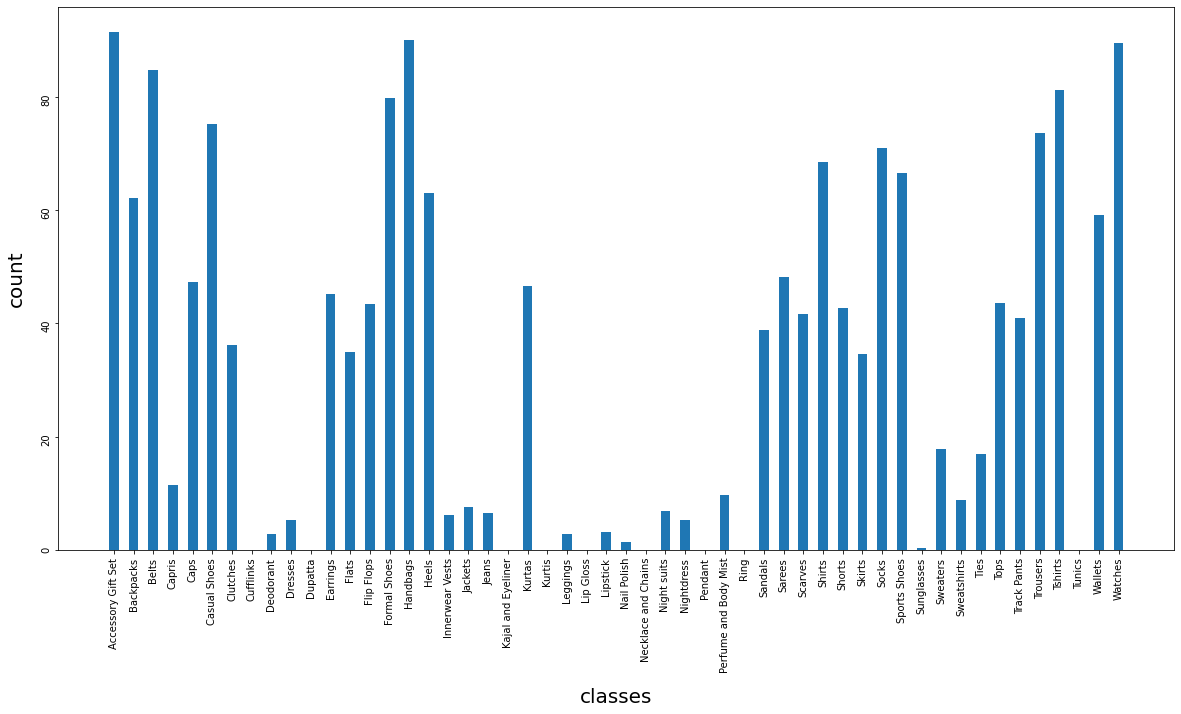

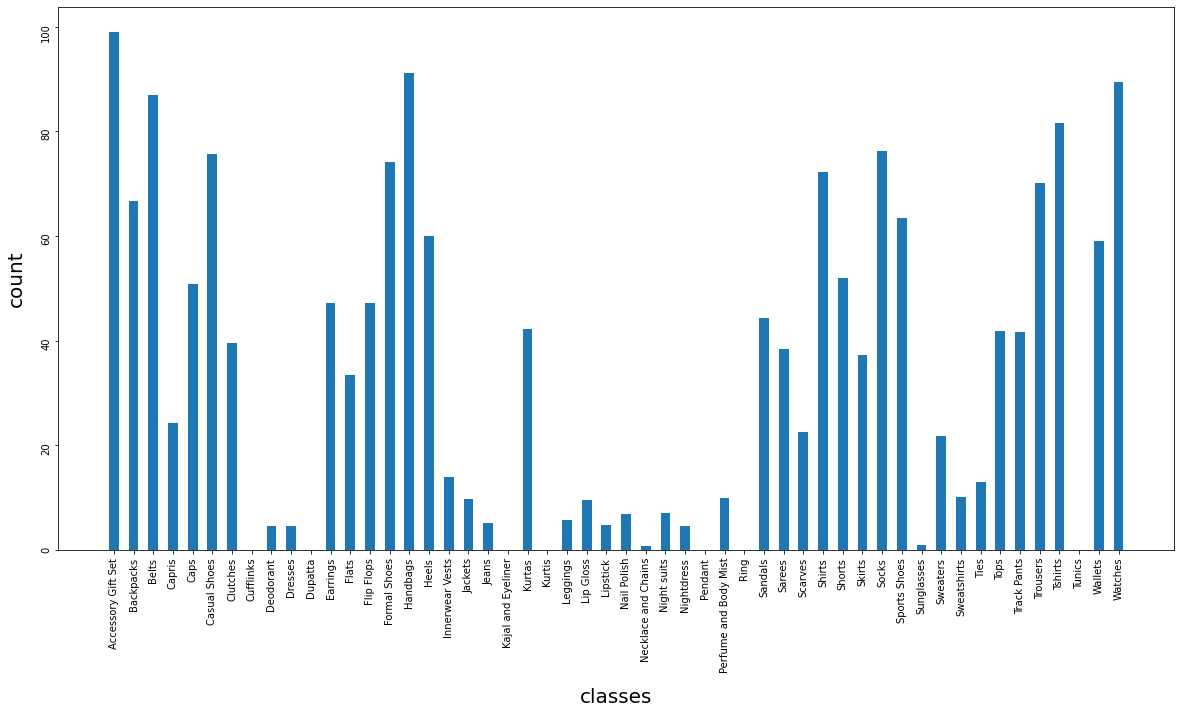

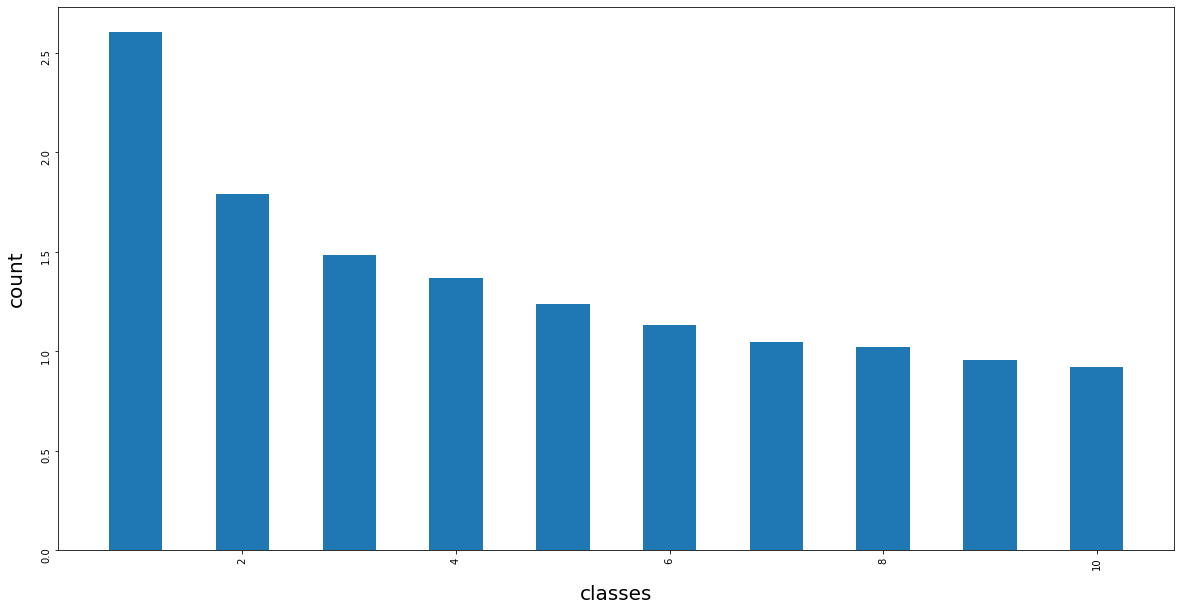

In [ ]:
printOutPuts(model19, train_loader19, test_loader19, classes2, avgLossOfEpochs19)

epoch 1, train_loss: 3.099, time elapsed: 14.387909 seconds
epoch 2, train_loss: 2.638, time elapsed: 14.364982 seconds
epoch 3, train_loss: 3.247, time elapsed: 14.169546 seconds
epoch 4, train_loss: 3.456, time elapsed: 13.956782 seconds
epoch 5, train_loss: 3.455, time elapsed: 14.106019 seconds
epoch 6, train_loss: 3.454, time elapsed: 14.279286 seconds
epoch 7, train_loss: 3.455, time elapsed: 14.143336 seconds
epoch 8, train_loss: 3.454, time elapsed: 14.190484 seconds
epoch 9, train_loss: 3.455, time elapsed: 14.298002 seconds
epoch 10, train_loss: 3.454, time elapsed: 14.331871 seconds
total training time: 2.370 minutes
Test set accuracy:
Accuracy: 9.461991434689507%
{'Accessory Gift Set': [0.0, 23.0], 'Backpacks': [0.0, 145.0], 'Belts': [0.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [0.0, 57.0], 'Casual Shoes': [0.0, 570.0], 'Clutches': [0.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [0.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [0.0, 84.0], 'Flats

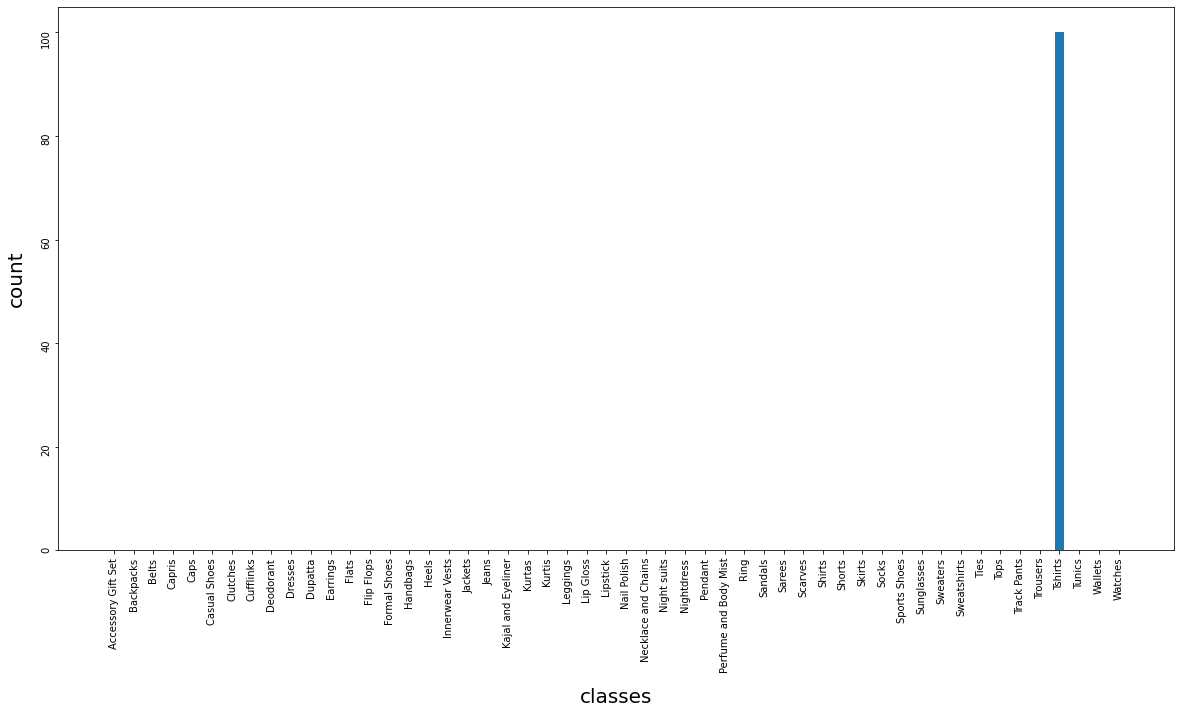

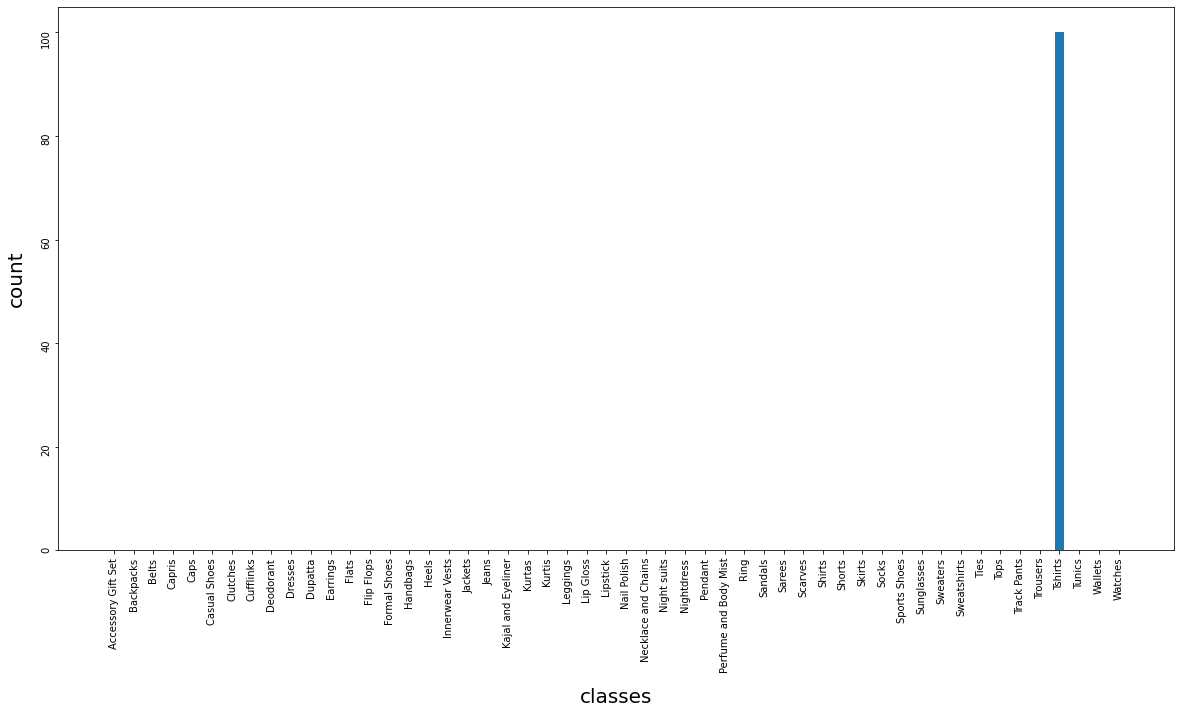

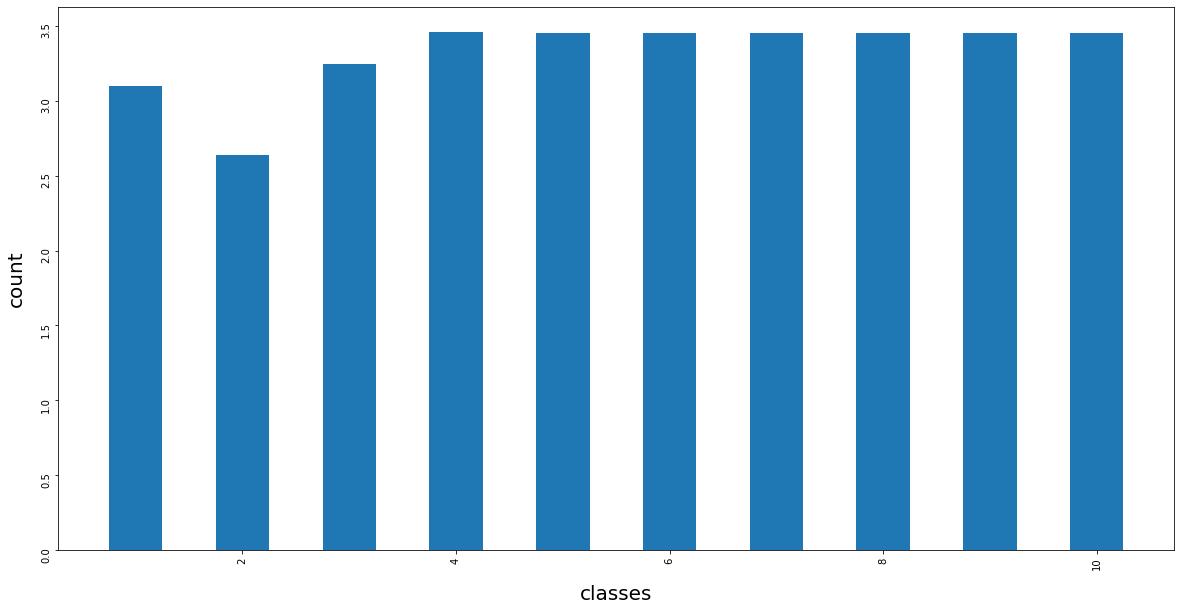

In [ ]:
model20, train_loader20, test_loader20, avgLossOfEpochs20 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, 0.9)
printOutPuts(model20, train_loader20, test_loader20, classes2, avgLossOfEpochs20)

epoch 1, train_loss: 3.427, time elapsed: 14.317706 seconds
epoch 2, train_loss: 3.461, time elapsed: 14.134559 seconds
epoch 3, train_loss: 3.461, time elapsed: 14.096011 seconds
epoch 4, train_loss: 3.460, time elapsed: 14.163088 seconds
epoch 5, train_loss: 3.462, time elapsed: 14.298458 seconds
epoch 6, train_loss: 3.463, time elapsed: 14.347592 seconds
epoch 7, train_loss: 3.460, time elapsed: 14.397233 seconds
epoch 8, train_loss: 3.459, time elapsed: 14.202798 seconds
epoch 9, train_loss: 3.461, time elapsed: 14.165173 seconds
epoch 10, train_loss: 3.459, time elapsed: 14.488438 seconds
total training time: 2.377 minutes
Test set accuracy:
Accuracy: 9.461991434689507%
{'Accessory Gift Set': [0.0, 23.0], 'Backpacks': [0.0, 145.0], 'Belts': [0.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [0.0, 57.0], 'Casual Shoes': [0.0, 570.0], 'Clutches': [0.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [0.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [0.0, 84.0], 'Flats

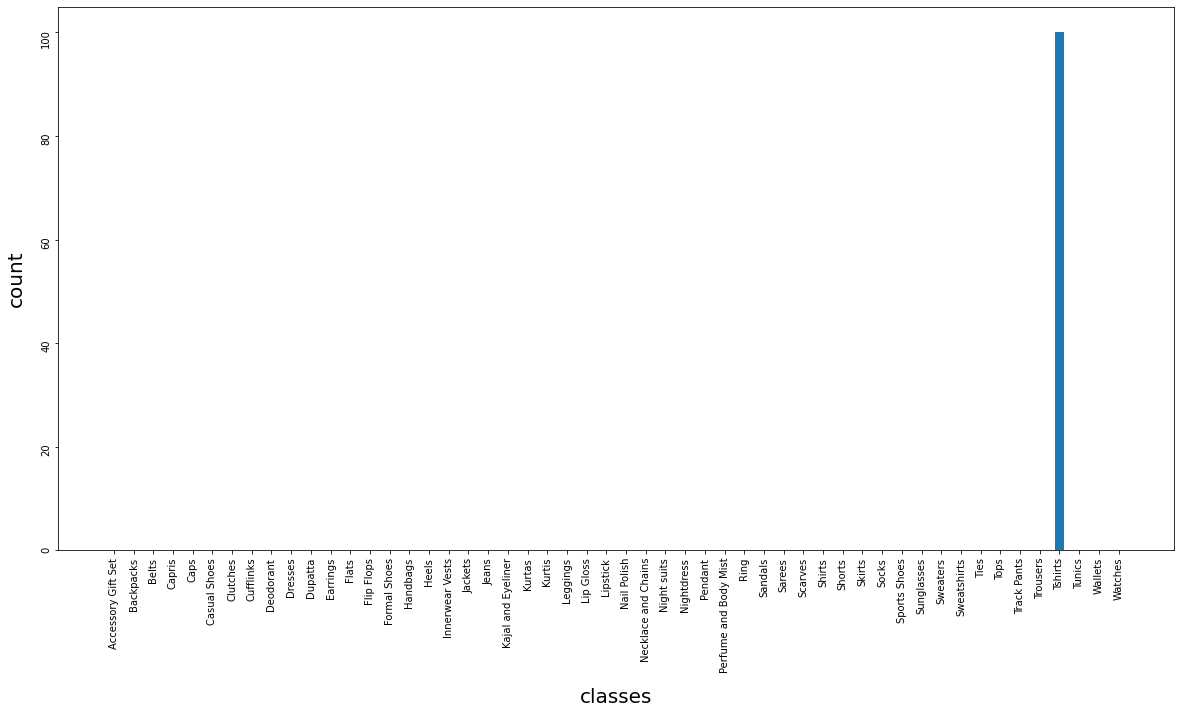

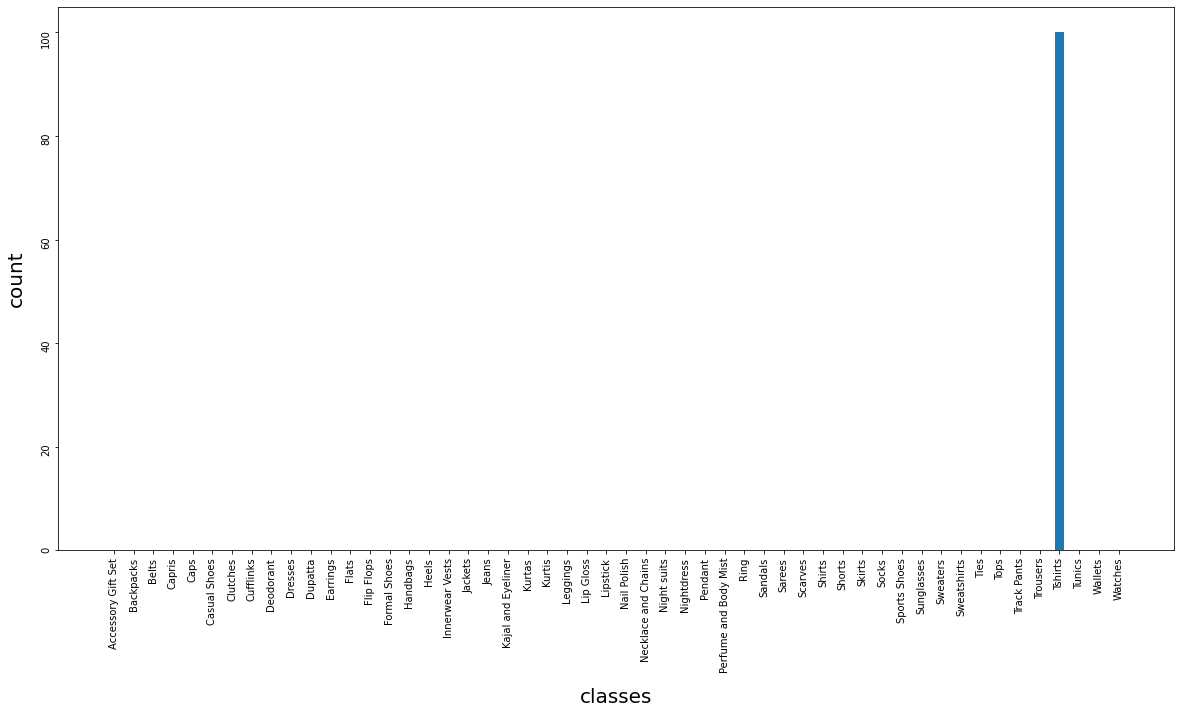

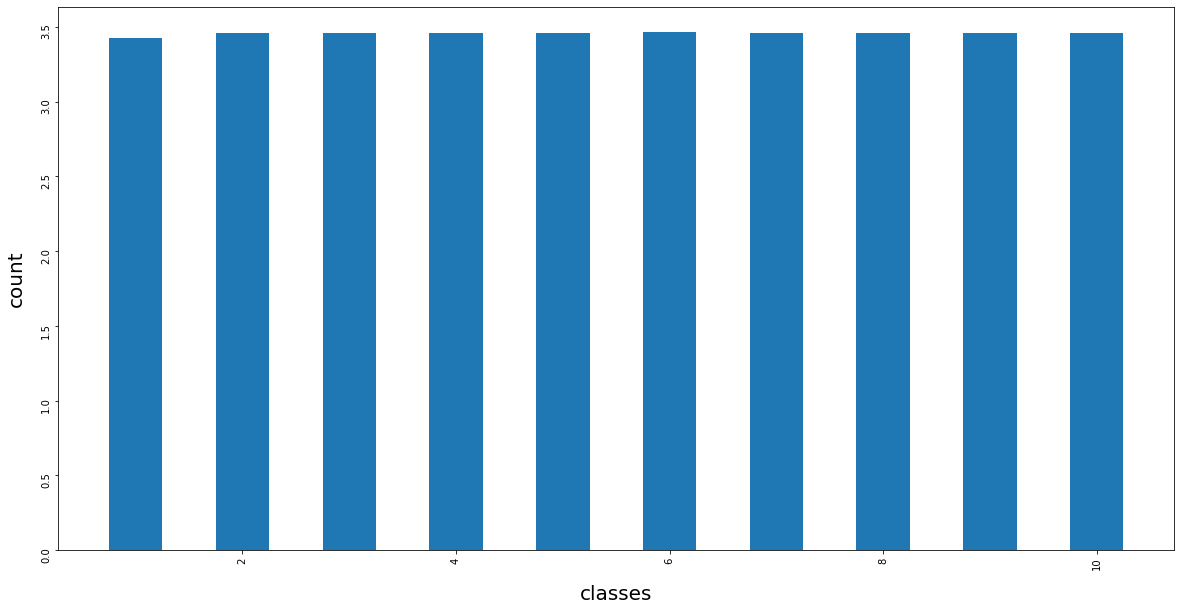

In [ ]:
model21, train_loader21, test_loader21, avgLossOfEpochs21 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, 0.98)
printOutPuts(model21, train_loader21, test_loader21, classes2, avgLossOfEpochs21)

In [ ]:
bestMomentum = 0.5

Phase 9:

epoch 1, train_loss: 2.746, time elapsed: 14.407197 seconds
epoch 2, train_loss: 1.883, time elapsed: 14.633222 seconds
epoch 3, train_loss: 1.569, time elapsed: 14.231275 seconds
epoch 4, train_loss: 1.361, time elapsed: 14.587677 seconds
epoch 5, train_loss: 1.241, time elapsed: 14.411808 seconds
epoch 6, train_loss: 1.159, time elapsed: 14.359369 seconds
epoch 7, train_loss: 1.107, time elapsed: 14.562215 seconds
epoch 8, train_loss: 1.045, time elapsed: 14.190521 seconds
epoch 9, train_loss: 0.985, time elapsed: 14.24131 seconds
epoch 10, train_loss: 0.945, time elapsed: 14.026099 seconds
epoch 11, train_loss: 0.910, time elapsed: 13.930418 seconds
epoch 12, train_loss: 0.870, time elapsed: 14.03606 seconds
epoch 13, train_loss: 0.841, time elapsed: 13.976166 seconds
epoch 14, train_loss: 0.829, time elapsed: 14.030841 seconds
epoch 15, train_loss: 0.802, time elapsed: 13.868788 seconds
epoch 16, train_loss: 0.777, time elapsed: 13.817262 seconds
epoch 17, train_loss: 0.752, time e

ValueError: ignored

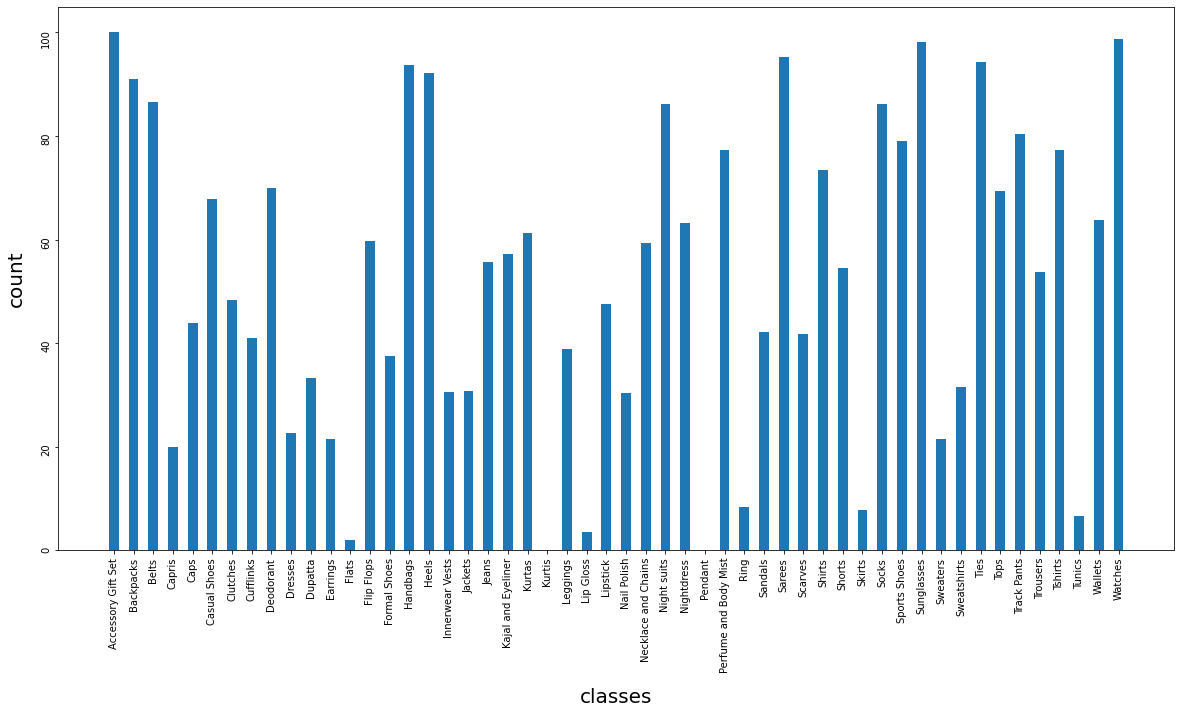

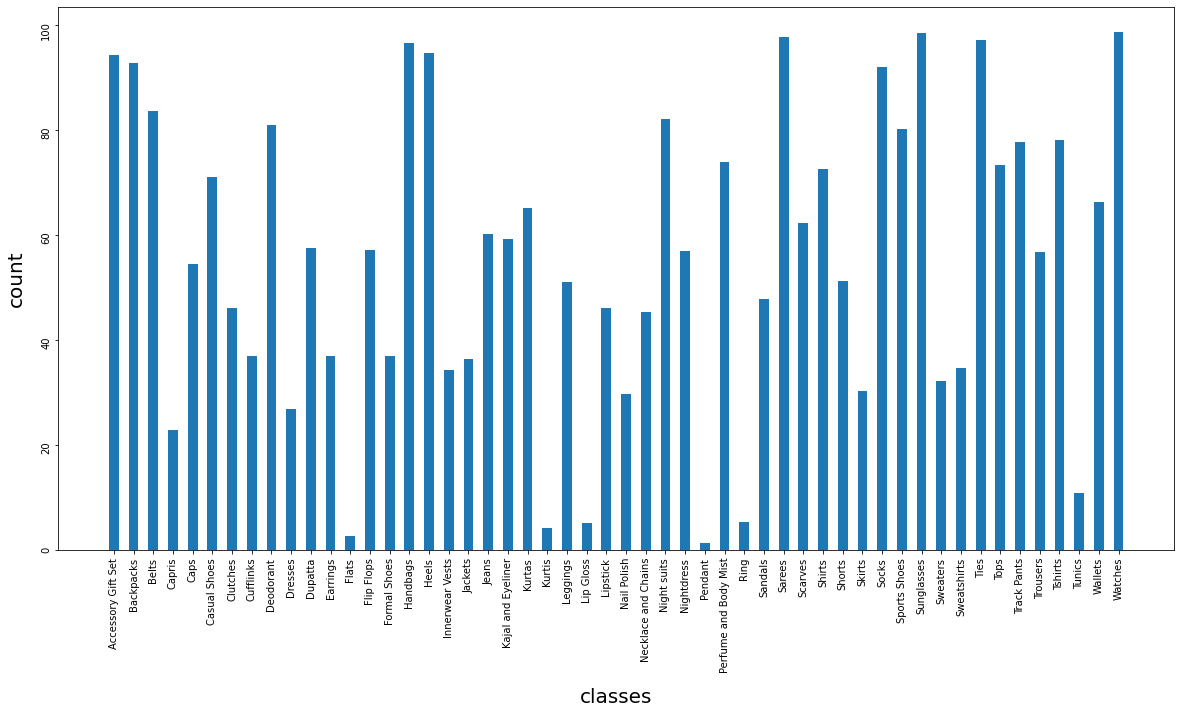

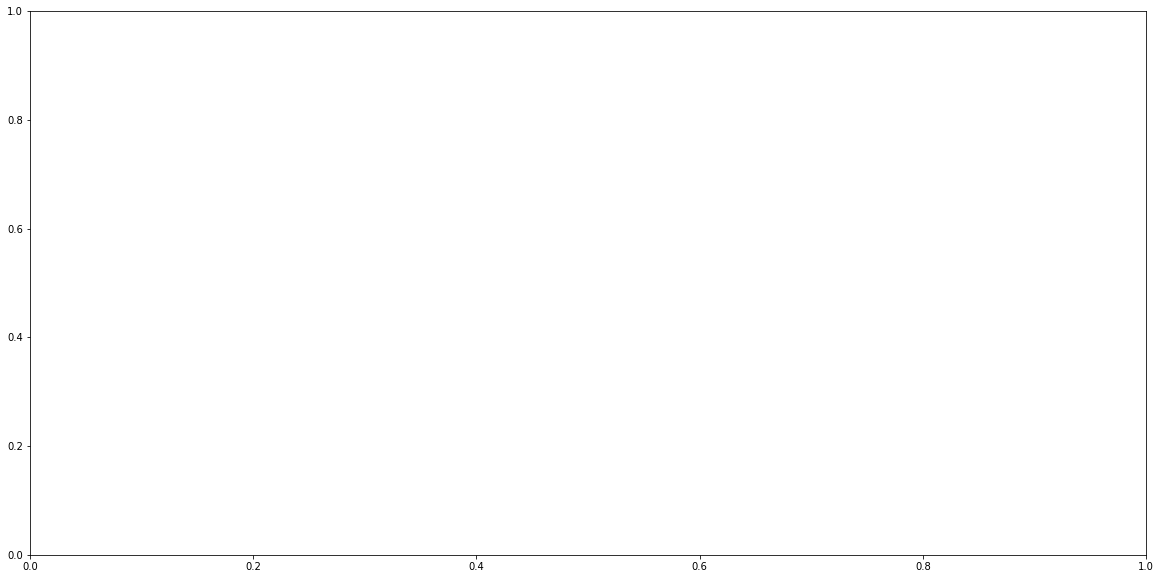

In [ ]:
model22, train_loader22, test_loader22, avgLossOfEpochs22 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, bestMomentum, False, 20)
printOutPuts(model22, train_loader22, test_loader22, classes2, avgLossOfEpochs22)

In [ ]:
print(avgLossOfEpochs22)

[2.745922364902087, 1.8831164174325477, 1.5694232948859874, 1.3605488571997877, 1.240844601725304, 1.1593859456639433, 1.1071087380335567, 1.0447761048063189, 0.9851058183054044, 0.9448346290977216, 0.9103575204319196, 0.8696828004884106, 0.8406022783896442, 0.8288433361206955, 0.8023514557677789, 0.7765649033334634, 0.7515050104375561, 0.7308301330252267, 0.7146401185334497, 0.7014612568294541]


Text(0, 0.5, 'Test Accuracy')

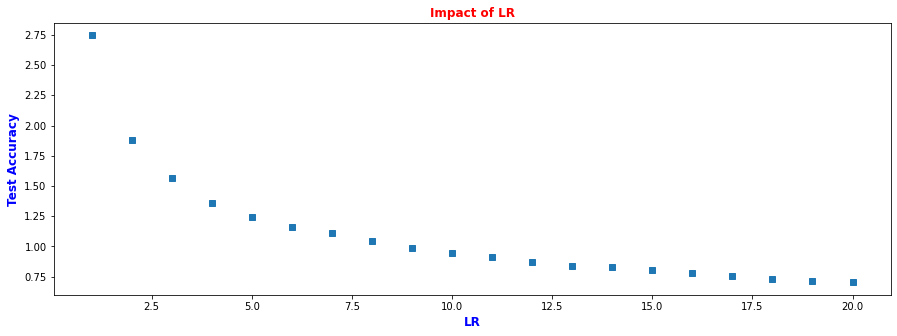

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(list(range(1,21)), avgLossOfEpochs22, 's')
plt.title('Impact of LR', weight='bold', size='large', color = 'r')
plt.xlabel('LR', weight='bold', size='large', color = 'b')
plt.ylabel('Test Accuracy', weight='bold', size='large', color = 'b')

Text(0, 0.5, 'Test Accuracy')

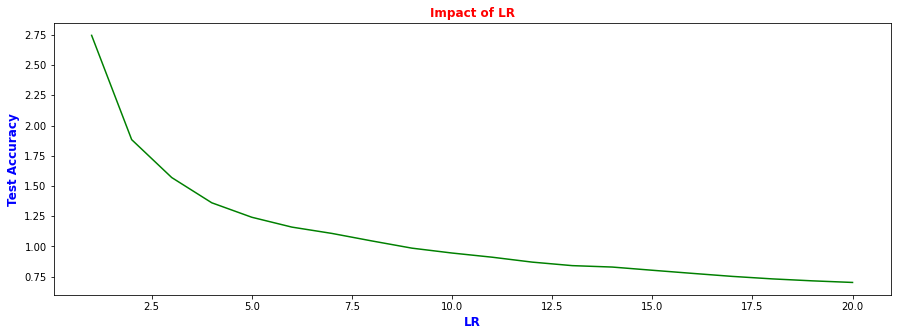

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(list(range(1,21)), avgLossOfEpochs22, color = 'g')
plt.title('Impact of LR', weight='bold', size='large', color = 'r')
plt.xlabel('LR', weight='bold', size='large', color = 'b')
plt.ylabel('Test Accuracy', weight='bold', size='large', color = 'b')

همانطور که دیده میشود دقت خیلی خوبی داریم.
افزایش تعداد دوره ها باعث میشود که مدل مرحله به مرحله به جواب بهتر همگرا شود. تعداد دوره ها را از 1 بیشتر میگذاریم زیرا باعث میشود که در هر بار از یک نقطه جدید شروع کنیم و بنابراین احتمال این که در مینیمم محلی گیر بیفتیم را کم میکند و در هر دوره با بررسی داده ها به جواب بهتر میرسیم. اما اگر تعداد دوره ها را خیلی زیاد کنیم، همانطور که انتظار میرود باعث اورفیتینگ میشود و روی داده آموزش خیلی دقیق میشویم و روی آن خیلی فیت میشویم و در مواجهه با داده جدید خوب عمل نمیکنیم و دقت کمی داریم. همچنین در مواردی که به طور مثال پارامتر هایی مثل نرخ یادگیری کم هستند، سرعت آموزش پایین است و باید تعداد دوره ها را بیشتر کنیم و با یک دوره به جواب خوبی نمیرسیم.

Phase 10:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 1, train_loss: 2.128, time elapsed: 14.398618 seconds
epoch 2, train_loss: 1.457, time elapsed: 14.346764 seconds
epoch 3, train_loss: 1.256, time elapsed: 14.127081 seconds
epoch 4, train_loss: 1.145, time elapsed: 14.005572 seconds
epoch 5, train_loss: 1.053, time elapsed: 13.971968 seconds
epoch 6, train_loss: 1.000, time elapsed: 13.833609 seconds
epoch 7, train_loss: 0.944, time elapsed: 13.815554 seconds
epoch 8, train_loss: 0.901, time elapsed: 13.792404 seconds
epoch 9, train_loss: 0.867, time elapsed: 13.797686 seconds
epoch 10, train_loss: 0.834, time elapsed: 13.82896 seconds
total training time: 2.332 minutes
Test set accuracy:
Accuracy: 65.9127408993576%
{'Accessory Gift Set': [23.0, 23.0], 'Backpacks': [135.0, 145.0], 'Belts': [151.0, 163.0], 'Capris': [19.0, 35.0], 'Caps': [44.0, 57.0], 'Casual Shoes': [298.0, 570.0], 'Clutches': [28.0, 58.0], 'Cufflinks': [15.0, 22.0], 'Deodorant': [52.0, 70.0], 'Dresses': [21.0, 93.0], 'Dupatta': [15.0, 24.0], 'Earrings': [59.0, 

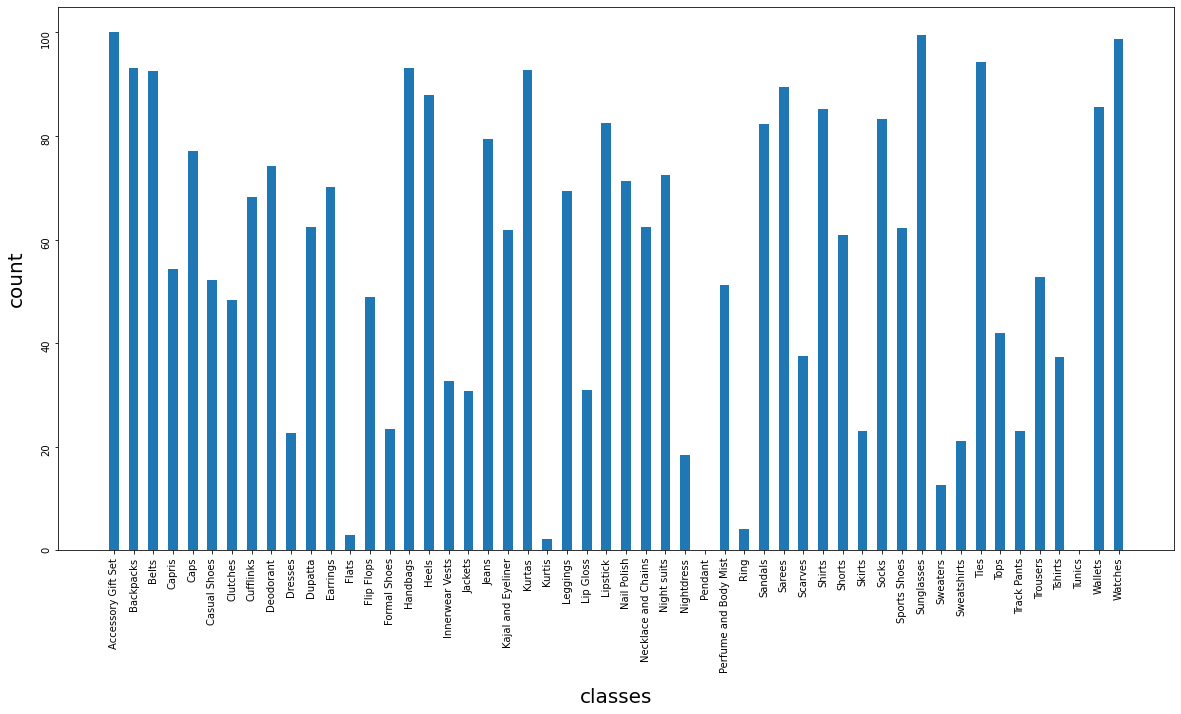

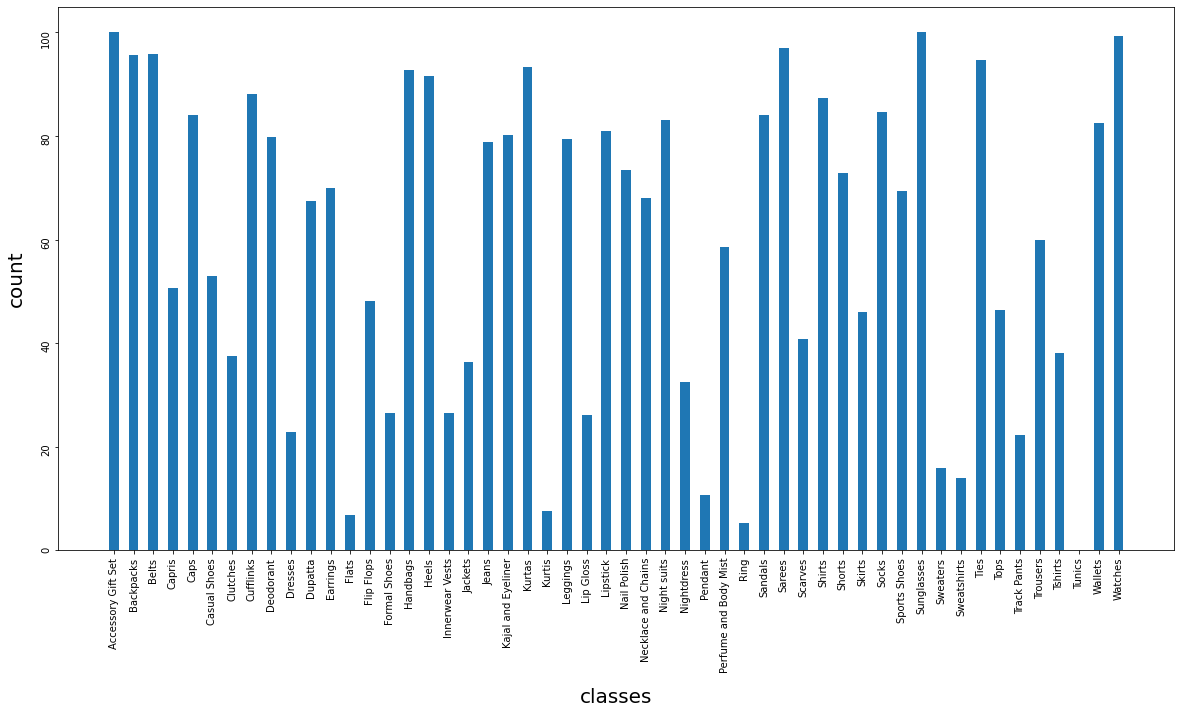

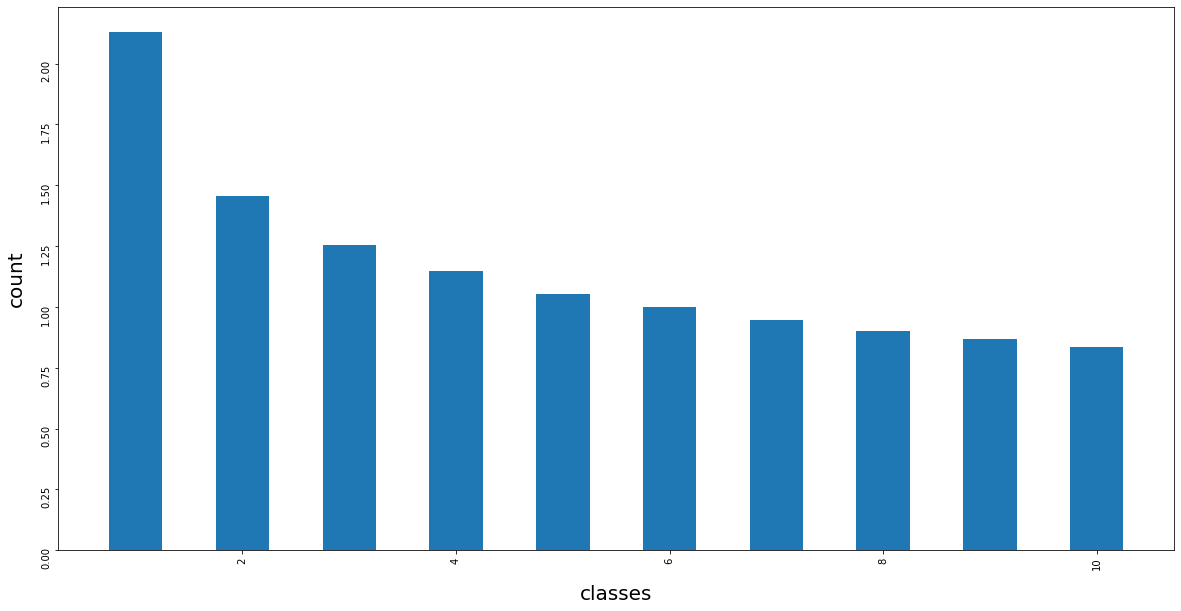

In [ ]:
model23, train_loader23, test_loader23, avgLossOfEpochs23 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, bestMomentum, False, 10, F.tanh)
printOutPuts(model23, train_loader23, test_loader23, classes2, avgLossOfEpochs23)

epoch 1, train_loss: 2.133, time elapsed: 14.407277 seconds
epoch 2, train_loss: 1.449, time elapsed: 14.179472 seconds
epoch 3, train_loss: 1.255, time elapsed: 14.268145 seconds
epoch 4, train_loss: 1.140, time elapsed: 13.969065 seconds
epoch 5, train_loss: 1.058, time elapsed: 14.222488 seconds
epoch 6, train_loss: 1.002, time elapsed: 14.062589 seconds
epoch 7, train_loss: 0.944, time elapsed: 14.057507 seconds
epoch 8, train_loss: 0.898, time elapsed: 14.166086 seconds
epoch 9, train_loss: 0.862, time elapsed: 14.328608 seconds
epoch 10, train_loss: 0.831, time elapsed: 14.176969 seconds
total training time: 2.364 minutes
Test set accuracy:
Accuracy: 64.03907922912205%
{'Accessory Gift Set': [23.0, 23.0], 'Backpacks': [134.0, 145.0], 'Belts': [161.0, 163.0], 'Capris': [12.0, 35.0], 'Caps': [38.0, 57.0], 'Casual Shoes': [259.0, 570.0], 'Clutches': [19.0, 58.0], 'Cufflinks': [13.0, 22.0], 'Deodorant': [55.0, 70.0], 'Dresses': [9.0, 93.0], 'Dupatta': [8.0, 24.0], 'Earrings': [12.0, 

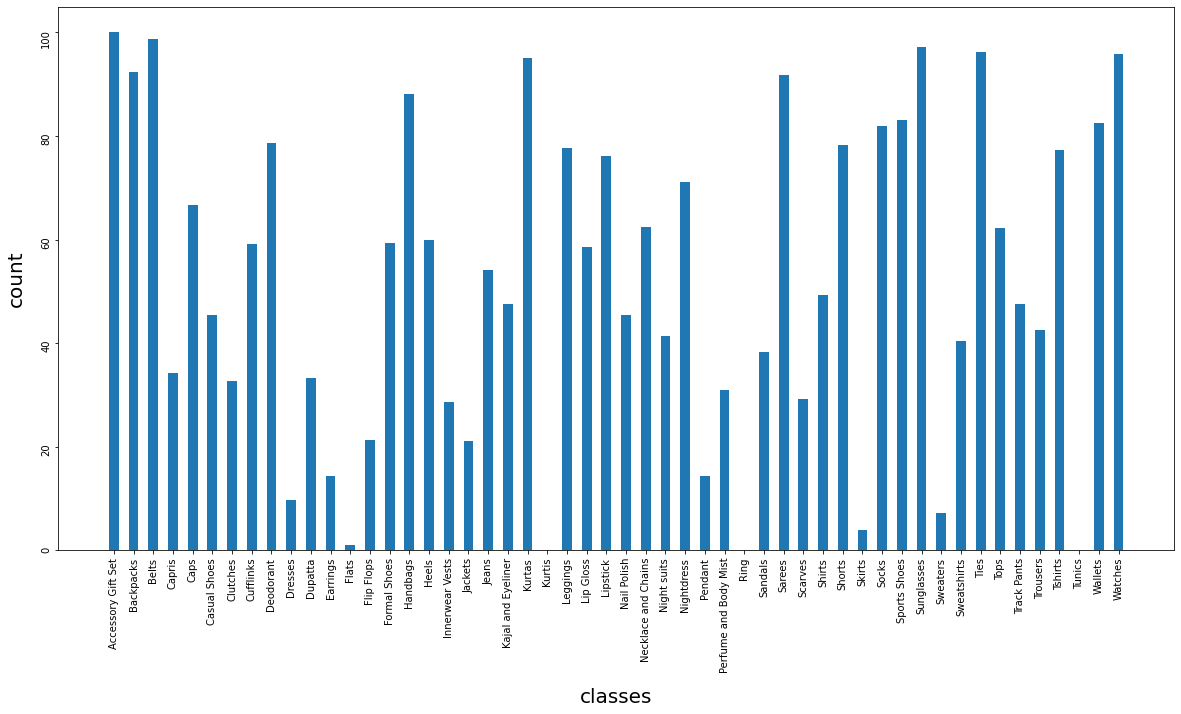

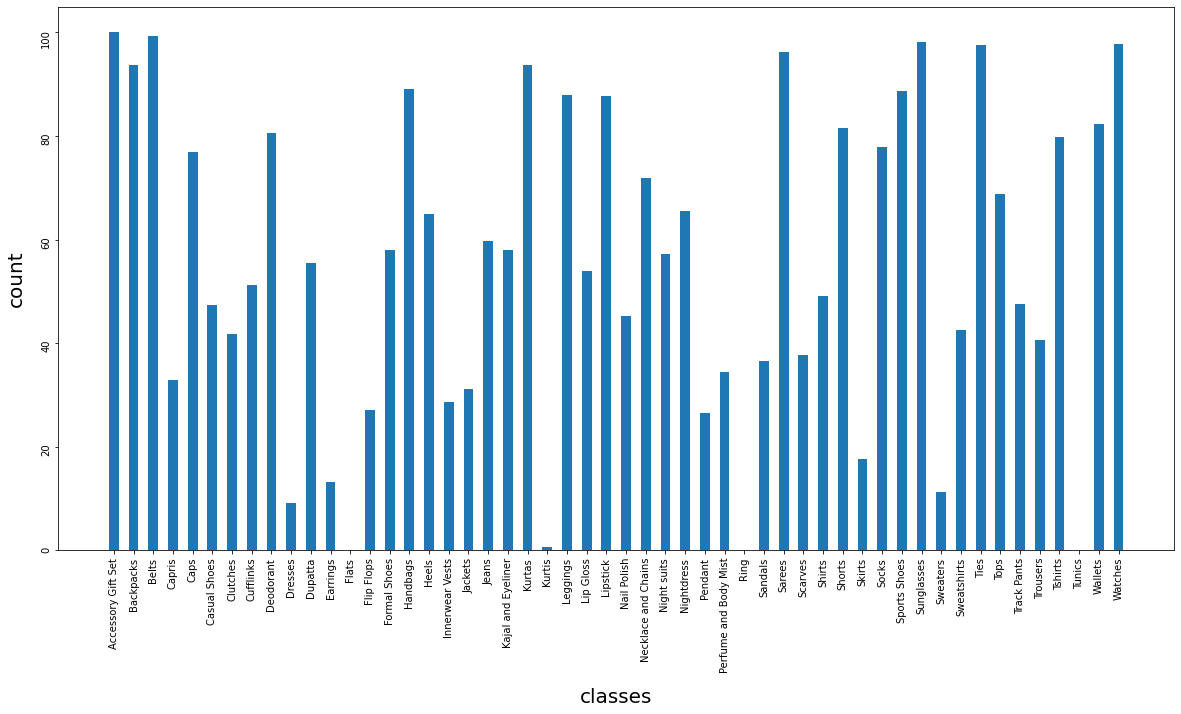

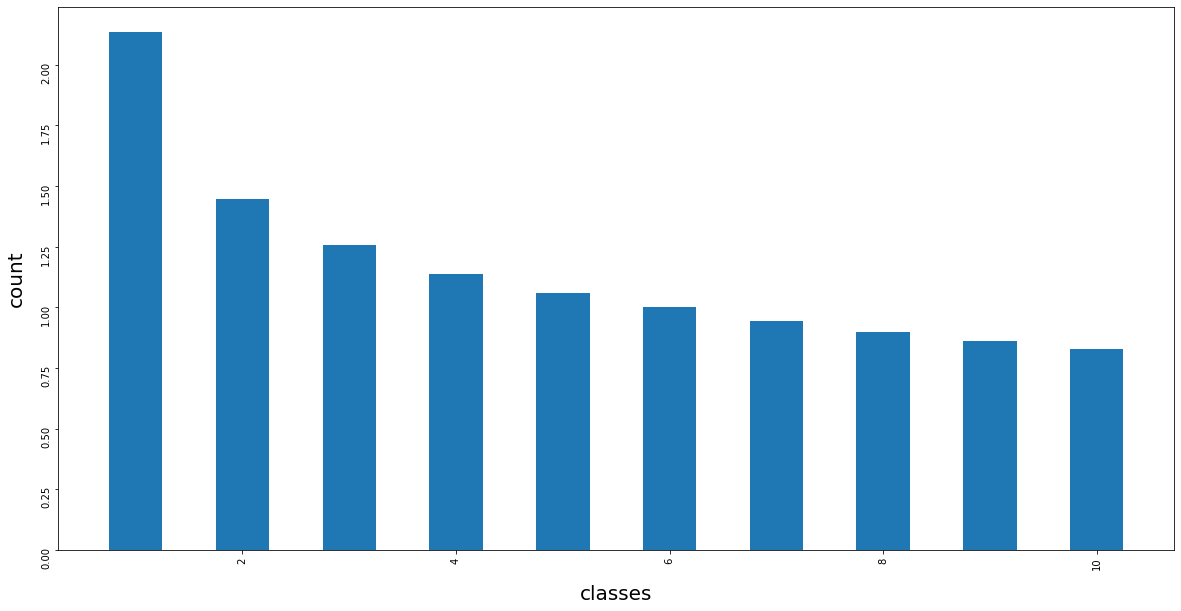

In [ ]:
model24, train_loader24, test_loader24, avgLossOfEpochs24 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, bestMomentum, False, 10, torch.tanh)
printOutPuts(model24, train_loader24, test_loader24, classes2, avgLossOfEpochs24)

epoch 1, train_loss: 2.641, time elapsed: 15.46075 seconds
epoch 2, train_loss: 1.829, time elapsed: 13.853976 seconds
epoch 3, train_loss: 1.470, time elapsed: 13.928468 seconds
epoch 4, train_loss: 1.342, time elapsed: 13.765049 seconds
epoch 5, train_loss: 1.214, time elapsed: 13.994941 seconds
epoch 6, train_loss: 1.125, time elapsed: 14.231362 seconds
epoch 7, train_loss: 1.073, time elapsed: 13.908474 seconds
epoch 8, train_loss: 1.018, time elapsed: 13.839076 seconds
epoch 9, train_loss: 0.959, time elapsed: 13.828961 seconds
epoch 10, train_loss: 0.924, time elapsed: 13.58612 seconds
total training time: 2.340 minutes
Test set accuracy:
Accuracy: 59.16755888650964%
{'Accessory Gift Set': [23.0, 23.0], 'Backpacks': [139.0, 145.0], 'Belts': [160.0, 163.0], 'Capris': [3.0, 35.0], 'Caps': [43.0, 57.0], 'Casual Shoes': [70.0, 570.0], 'Clutches': [29.0, 58.0], 'Cufflinks': [7.0, 22.0], 'Deodorant': [10.0, 70.0], 'Dresses': [10.0, 93.0], 'Dupatta': [7.0, 24.0], 'Earrings': [73.0, 84.0

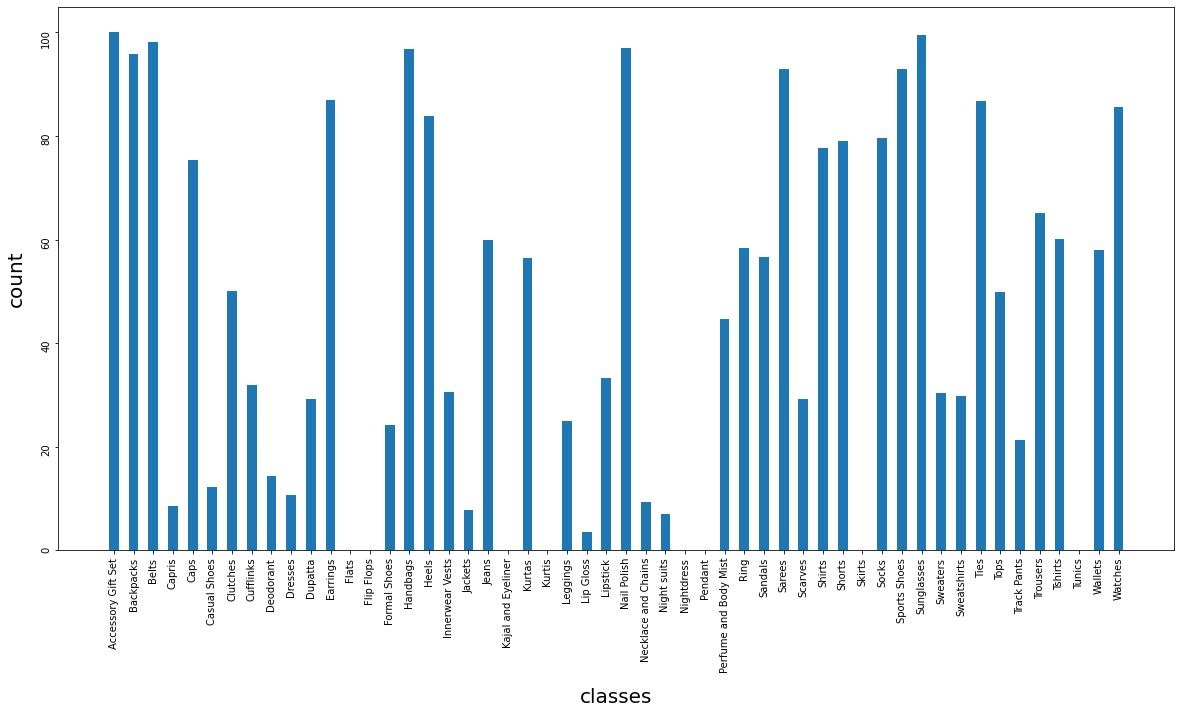

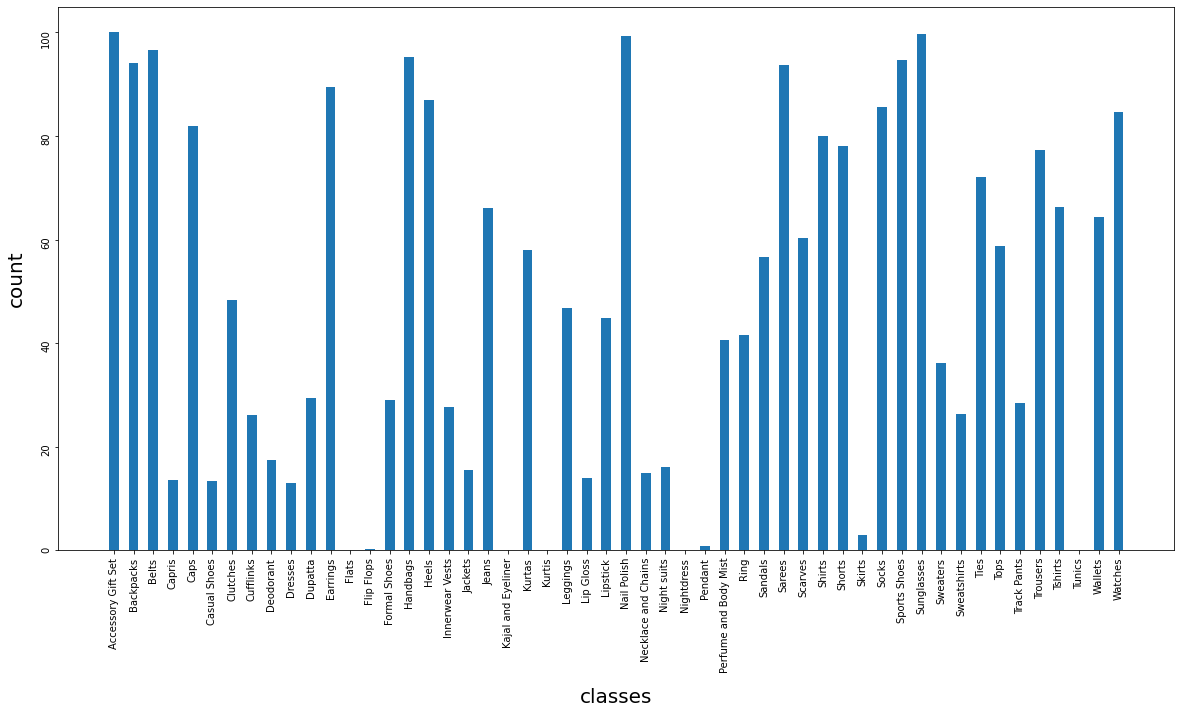

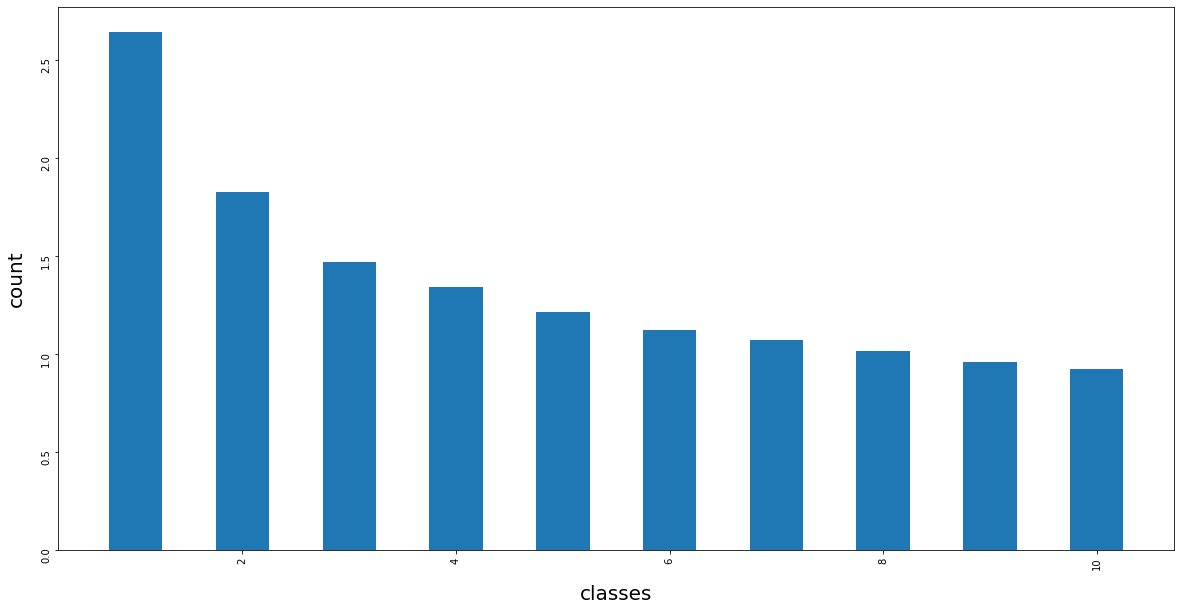

In [ ]:
model25, train_loader25, test_loader25, avgLossOfEpochs25 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, bestMomentum, False, 10)
printOutPuts(model25, train_loader25, test_loader25, classes2, avgLossOfEpochs25)

epoch 1, train_loss: 2.630, time elapsed: 14.165674 seconds
epoch 2, train_loss: 1.816, time elapsed: 13.696771 seconds
epoch 3, train_loss: 1.492, time elapsed: 13.765073 seconds
epoch 4, train_loss: 1.334, time elapsed: 13.679793 seconds
epoch 5, train_loss: 1.230, time elapsed: 13.820064 seconds
epoch 6, train_loss: 1.139, time elapsed: 13.798599 seconds
epoch 7, train_loss: 1.065, time elapsed: 13.981438 seconds
epoch 8, train_loss: 1.014, time elapsed: 13.782773 seconds
epoch 9, train_loss: 0.969, time elapsed: 13.691419 seconds
epoch 10, train_loss: 0.930, time elapsed: 14.019948 seconds
total training time: 2.307 minutes
Test set accuracy:
Accuracy: 62.52676659528908%
{'Accessory Gift Set': [22.0, 23.0], 'Backpacks': [127.0, 145.0], 'Belts': [156.0, 163.0], 'Capris': [11.0, 35.0], 'Caps': [45.0, 57.0], 'Casual Shoes': [355.0, 570.0], 'Clutches': [18.0, 58.0], 'Cufflinks': [22.0, 22.0], 'Deodorant': [44.0, 70.0], 'Dresses': [13.0, 93.0], 'Dupatta': [16.0, 24.0], 'Earrings': [66.0

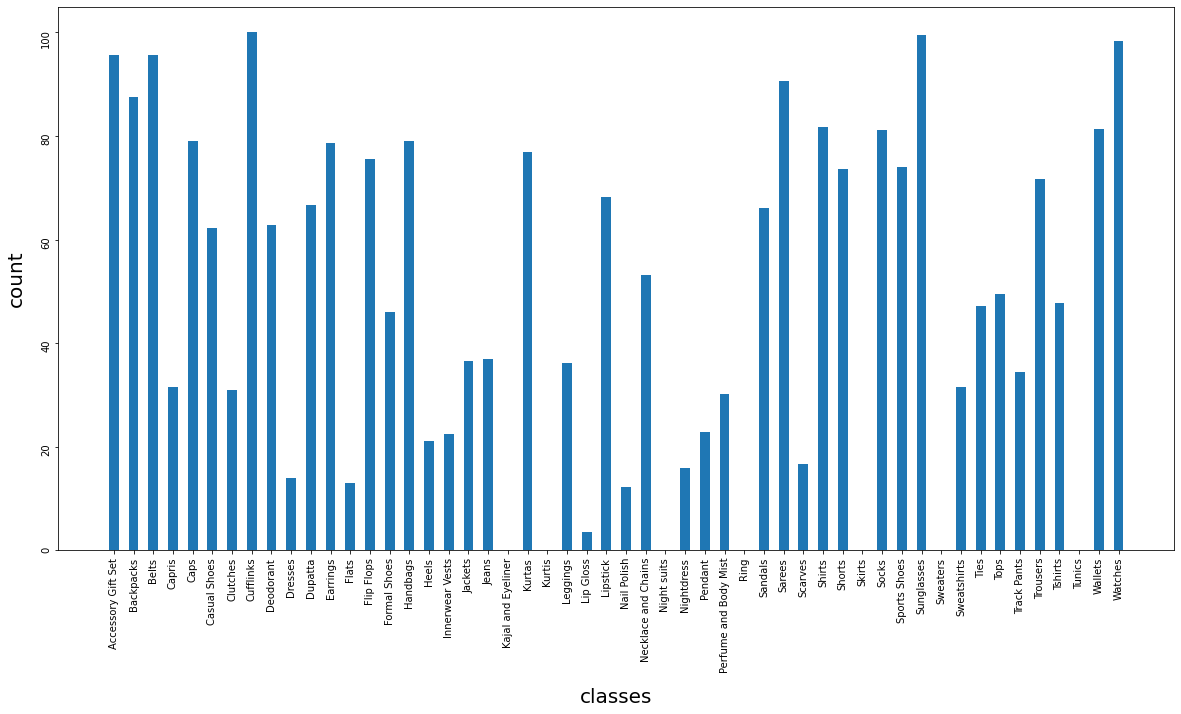

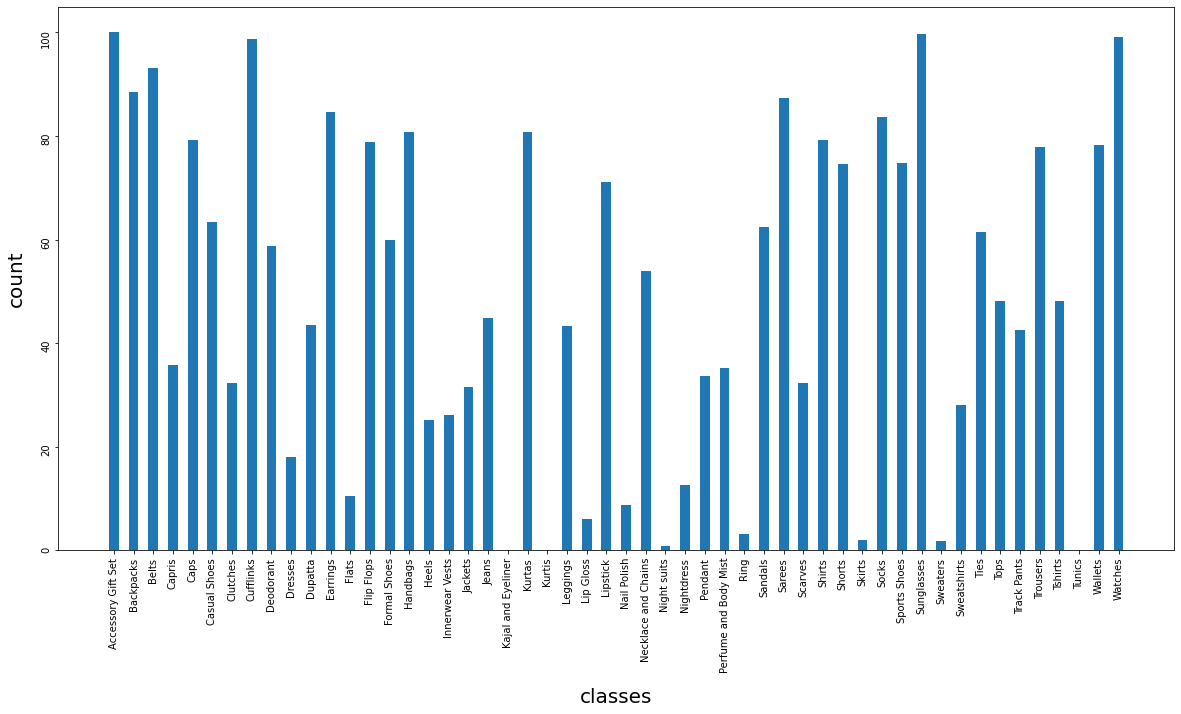

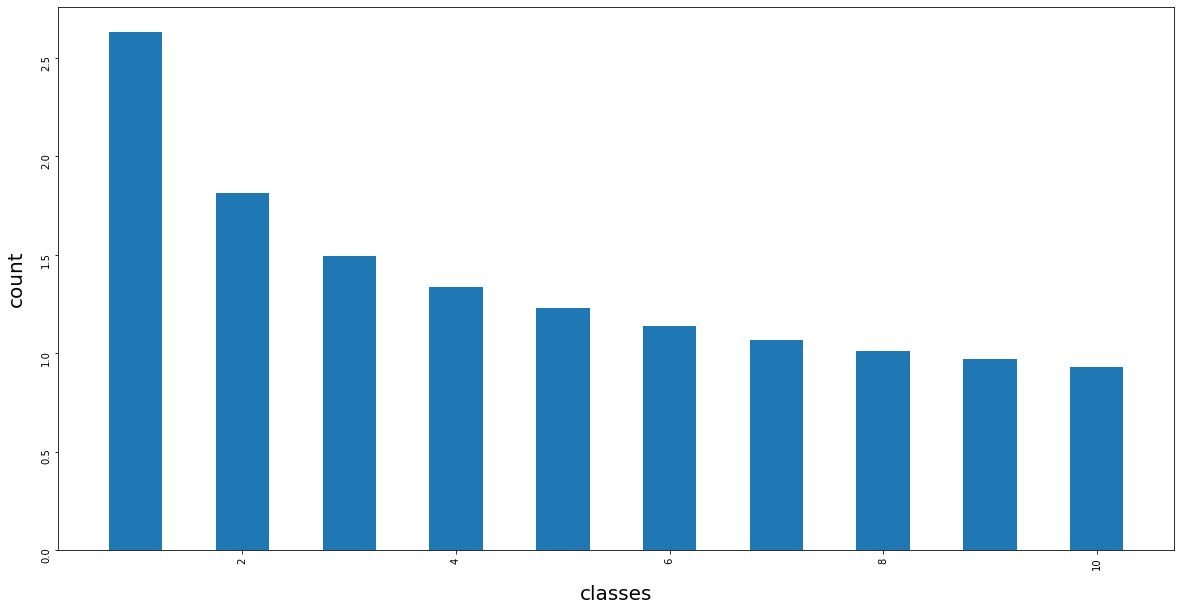

In [ ]:
model26, train_loader26, test_loader26, avgLossOfEpochs26 = createAndFitModel(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 64, False, False, bestMomentum, False, 10, F.leaky_relu)
printOutPuts(model26, train_loader26, test_loader26, classes2, avgLossOfEpochs26)

همانطور که دیده میشود دقت کمی بهتر میشود اما باز هم در یک اردر قرار دارند.
در حالت کلی چون relu پیاده سازی ساده ای دارد و راحت اپتیمایز میشود و سریع همگرا  میشود، در حالتی که از پیچیدگی مساله دید دقیقی نداشته باشیم میتوانیم از ۀن استفاده کنیم. و این تابع اجازه میدهد که صفر حقیقی داشته باشیم. اما چون به مقادیر منفی صفر نسبت میدهد، اگر نورونی منفی شود، با احتمال کمی ریکاور میشود. و برای لایه های میانی استفاده میشود.

leaky relu مشکل تابع قبلی در مواجهه با نورون منفی را حل میکند.

تابع tanh نیز سریع اپتیمایز میشود و از این نظر خوب است و میتواند مقادیر بین 1 و -1 را پوشش دهد.

Phase 11:

In [ ]:
def createAndFitModelWithRegulizer(dataset, classes, categorizedProducts, categorizedProductsIndices, criterion, learningRate, weightDecay, batchSize = 64, showDestribution = False, showModelParameters = False, momentum = 0, initializeWeights = False, numEpochs = 10, activationFunc = F.relu, validationSplit = 0.8):
    model = Model(len(classes), activationFunc)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=momentum, weight_decay = weightDecay)
    train_loader, test_loader, numOfEachProdTypeInTrainSet, numOfEachProdTypeInTestSet = createTestAndTrainData(categorizedProducts, categorizedProductsIndices, dataset, classes, batchSize, validationSplit)
    if showDestribution:
        printProductsDestribution(categorizedProducts, classes, numOfEachProdTypeInTrainSet, numOfEachProdTypeInTestSet)
    if showModelParameters:
        printModelParameters(model)
    if initializeWeights:
        model = initializeWeightsToZero(model)
    avgLossOfEpochs = fit(model, train_loader, device, criterion, optimizer, numEpochs)
    return model, train_loader, test_loader, avgLossOfEpochs

epoch 1, train_loss: 3.444, time elapsed: 14.042852 seconds
epoch 2, train_loss: 3.394, time elapsed: 13.960567 seconds
epoch 3, train_loss: 3.399, time elapsed: 13.900696 seconds
epoch 4, train_loss: 3.401, time elapsed: 13.728065 seconds
epoch 5, train_loss: 3.397, time elapsed: 13.932578 seconds
epoch 6, train_loss: 3.397, time elapsed: 13.980205 seconds
epoch 7, train_loss: 3.393, time elapsed: 13.631185 seconds
epoch 8, train_loss: 3.395, time elapsed: 13.939499 seconds
epoch 9, train_loss: 3.393, time elapsed: 13.654917 seconds
epoch 10, train_loss: 3.395, time elapsed: 13.944237 seconds
total training time: 2.312 minutes
Test set accuracy:
Accuracy: 8.632226980728051%
{'Accessory Gift Set': [0.0, 23.0], 'Backpacks': [0.0, 145.0], 'Belts': [0.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [0.0, 57.0], 'Casual Shoes': [10.0, 570.0], 'Clutches': [0.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [0.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [0.0, 84.0], 'Flat

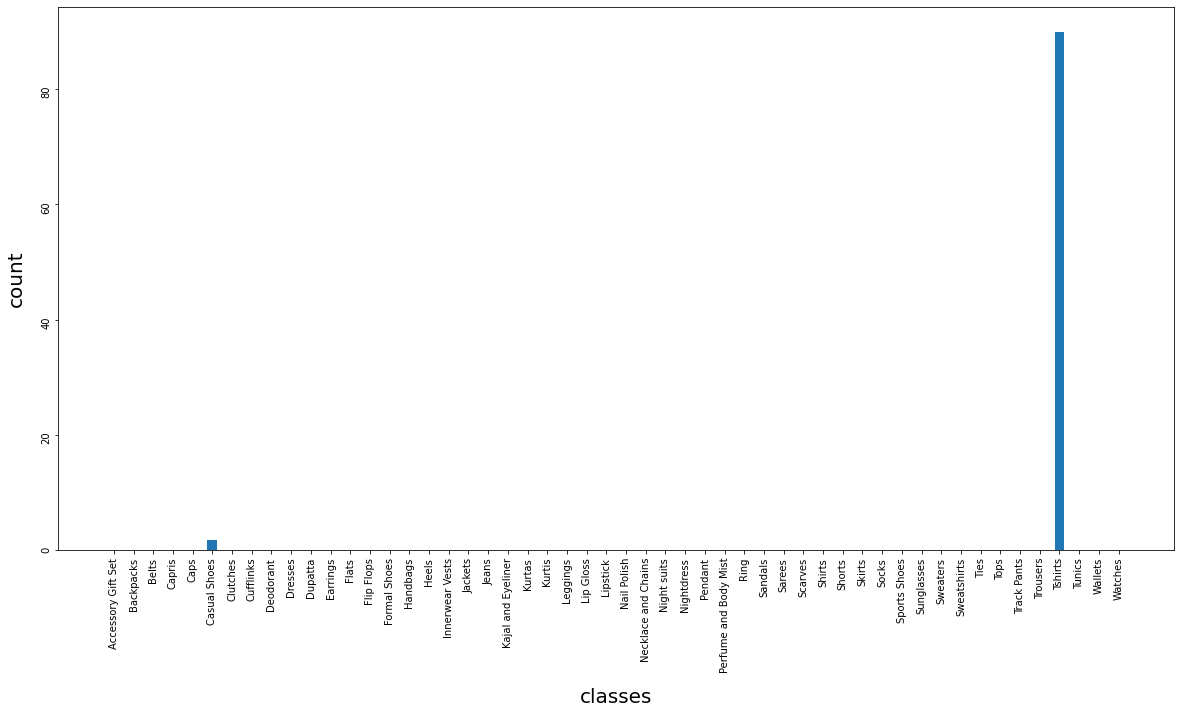

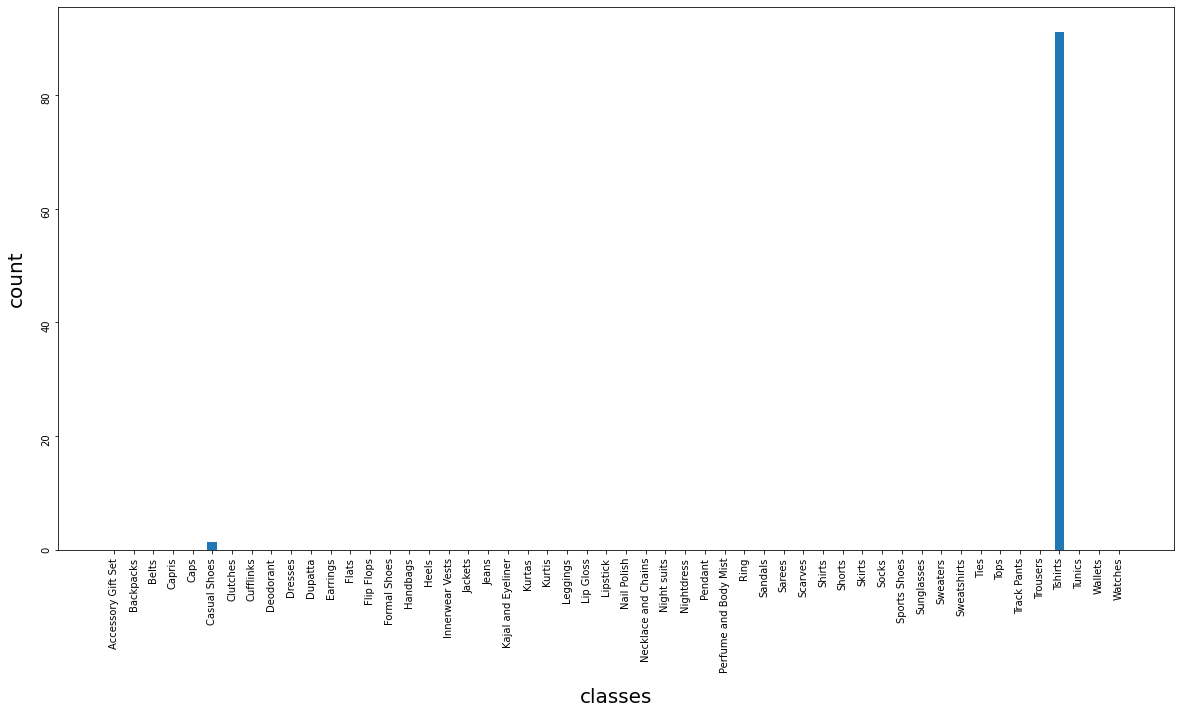

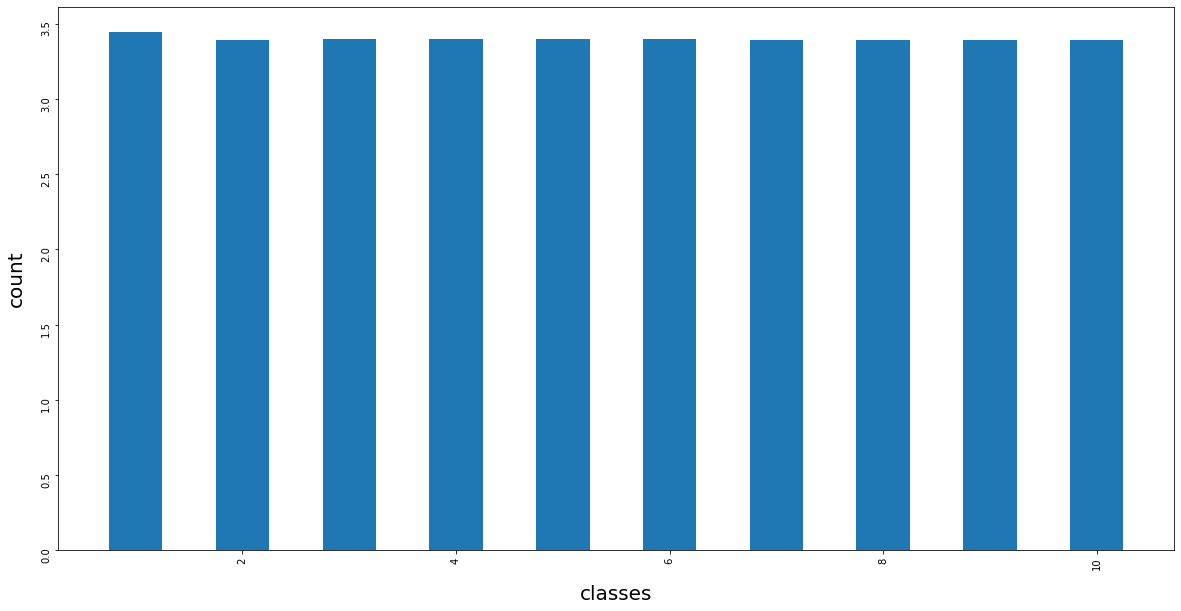

In [ ]:
model27, train_loader27, test_loader27, avgLossOfEpochs27 = createAndFitModelWithRegulizer(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 0.1, momentum = bestMomentum)
printOutPuts(model27, train_loader27, test_loader27, classes2, avgLossOfEpochs27)

از این روش برای جلوگیری از اورفیتینگ استفاده میشود. به این صورت که : اگر مدل ما خیلی پیچیده باشد، احتمال اورفیت شدن و اینکه روی داده آموزش خیلی دقیق شویم زیاد میشود. این روش تلاش میکند که با جلوگیری از بزرگ شدن وزن ها، از اورفیت شدن جلوگیری کند و جنرال بودن مدل را حفظ کند. در واقع عدد مربوط به این پارامتر هرچه بزرگ تر باشد، میزان تاثیر این روش بیشتر میشود و مدل ساده تر میشود و از حالت غیرخطی کمی خارج میشود و به شمت سادگی میرود و سعی میکند از اورفیتینگ جلوگیری کند. حال اگر مدل دچار اورفیت نشده باشد، استفاده از این روش و تخصیص مقدار زیاد به این پارامتر باعث میشود که آندرفیت اتفاق بیفتد و مدل بیش از حد ساده شود. و به این ترتیب دقت کم میشود. اما اگر مقدار آن را کم بدهیم (مثلا 0.01) مدل را کمتر ساده میکند و کمتر با اورفیت شدن مقابله میکند.
نتیجه ای که از این دقت به دست آمده میتوان گرفت این است که مدل ما زیاد دچار اورفیت نشده بوده که اعمال مقدار زیاد این پارامتر دقت را خیلی کاهش داده است.

افزودن رگیولایزر در لاس نیز همین تاثیر را میگذارد و مدل را ساده میکند تا از اورفیت شدن جلوگیری کند. و عملکرد این دو روش مثل هم است. زیرا رگیولار کردن لاس فانکشن و اینکه با وزن خیلی بزرگ مقابله کنیم و اجازه ندهیم و آزادی مدل را کم کنیم، با هم معادل هستند.

epoch 1, train_loss: 2.573, time elapsed: 14.304351 seconds
epoch 2, train_loss: 2.099, time elapsed: 14.21898 seconds
epoch 3, train_loss: 1.915, time elapsed: 14.132639 seconds
epoch 4, train_loss: 2.045, time elapsed: 14.033812 seconds
epoch 5, train_loss: 1.975, time elapsed: 14.159329 seconds
epoch 6, train_loss: 2.063, time elapsed: 13.862395 seconds
epoch 7, train_loss: 2.035, time elapsed: 13.856908 seconds
epoch 8, train_loss: 1.878, time elapsed: 14.113224 seconds
epoch 9, train_loss: 2.320, time elapsed: 14.397725 seconds
epoch 10, train_loss: 2.195, time elapsed: 13.802935 seconds
total training time: 2.348 minutes
Test set accuracy:
Accuracy: 34.595824411134906%
{'Accessory Gift Set': [0.0, 23.0], 'Backpacks': [114.0, 145.0], 'Belts': [55.0, 163.0], 'Capris': [0.0, 35.0], 'Caps': [0.0, 57.0], 'Casual Shoes': [0.0, 570.0], 'Clutches': [0.0, 58.0], 'Cufflinks': [0.0, 22.0], 'Deodorant': [5.0, 70.0], 'Dresses': [0.0, 93.0], 'Dupatta': [0.0, 24.0], 'Earrings': [13.0, 84.0], 'F

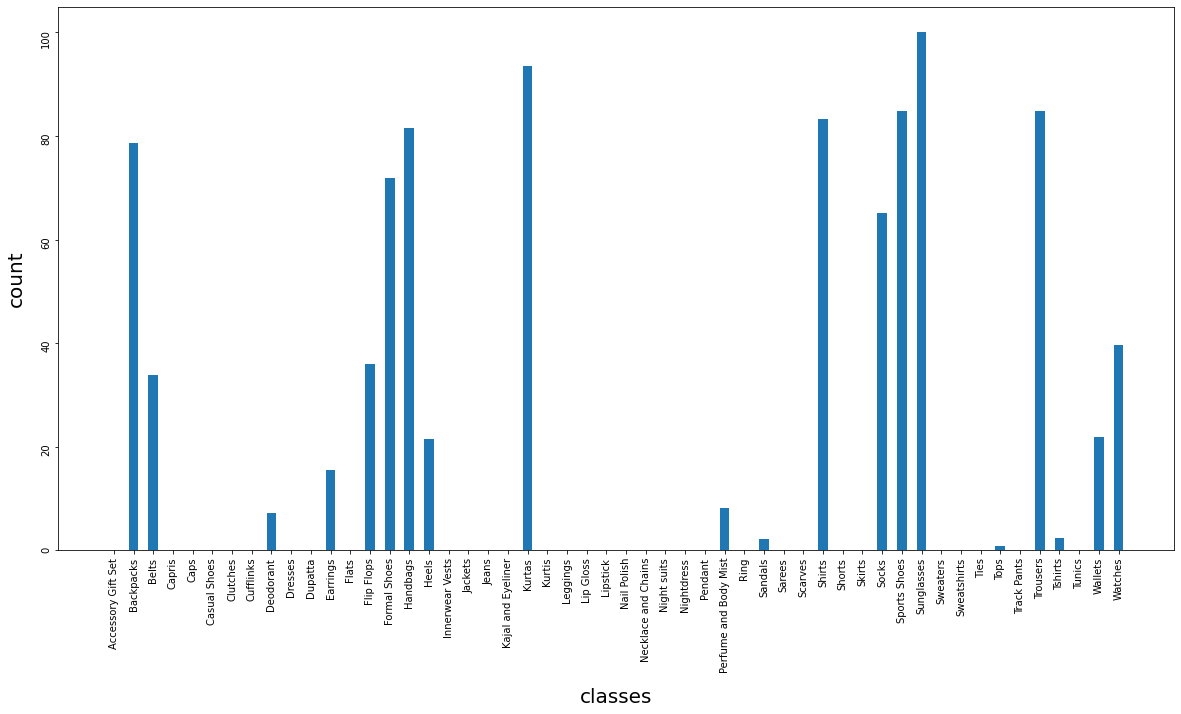

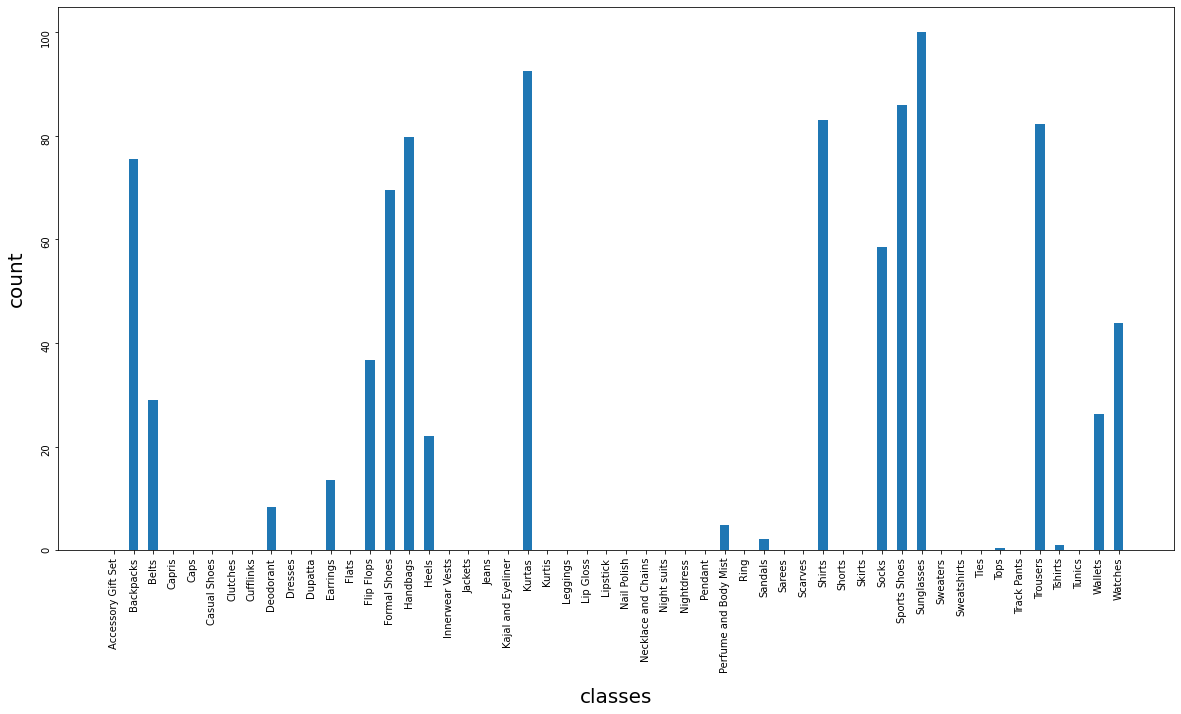

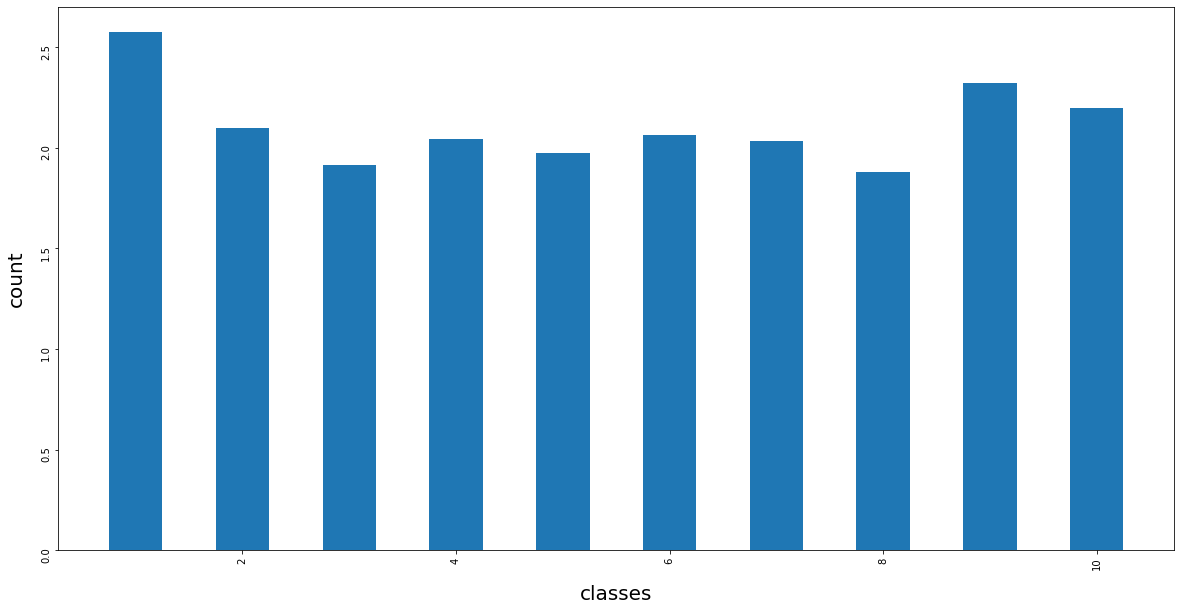

In [ ]:
model28, train_loader28, test_loader28, avgLossOfEpochs28 = createAndFitModelWithRegulizer(dataset2, classes2, categorizedProducts2, categorizedProductsIndices2, commonCriterion, bestLr, 0.01, momentum = bestMomentum)
printOutPuts(model28, train_loader28, test_loader28, classes2, avgLossOfEpochs28)

نسبت به بخش 8، در حالت اول که پارامتر را 0.1 قرار دادیم به همان نسبت دقت را خیلی کم کرد.
اما مقدار 0.01 نیز مدل را به دقت عادی برنگرداند و باز هم آن را بد تر کرد.
پس مدل دچار اورفیت نشده بوده و نیازی به ساده کردن آن نبوده